<a href="https://colab.research.google.com/github/Rob685/coolstarsucsd/blob/master/pred_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
from collections import Counter
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import LogNorm
import numpy as np
import scipy
from scipy import stats
import pandas as pd

from google.colab import drive #to import my own module, I must first follow this procedure:
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [64]:
plt.rcParams['figure.facecolor'] = 'white'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5) # change back to 1.5
plt.rc('axes', labelsize=10) # change back to 10
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=7) # change back to 7

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
#! sudo apt-get install dvipng texlive-fonts-recommended #2
! sudo apt-get install cm-super
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended 
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [4]:
path_smss = 'gdrive/My Drive/Colab Notebooks/sm_workspace/'
path_des = 'gdrive/My Drive/Colab Notebooks/des_workspace/des_dered_data/'
path_ml = 'gdrive/My Drive/Colab Notebooks/ml_preds/'

# Reading data

In [5]:
smss_tset = pd.read_csv(path_smss+'smss_red_trainingset_nodupes.csv.gz',compression='gzip',low_memory=False)
print('Training set shape:',smss_tset.shape)
print(Counter(smss_tset['label']))
print(Counter(smss_tset['survey_marker']))

Training set shape: (28849, 368)
Counter({'lm*': 28768, 'hm*': 81})
Counter({'smss_gaia_parallax': 28639, 'gagne_m': 137, 'kiman': 67, 'gagne_lty': 6})


In [6]:
smss_refset = pd.read_csv(path_smss+'smss_merged3.csv.gz',compression='gzip',low_memory=False)
print('skymapper refset shape:',smss_refset.shape)

skymapper refset shape: (36262, 363)


In [7]:
smss_preds = pd.read_csv(path_ml+'smss_preds_ktuner_biased_weighted2.csv.gz',compression='gzip',low_memory=False)
#smss_preds = smss_preds[smss_preds['i_psf'] - smss_preds['z_psf'] >= 0.75]
print('skymapper predictions:',smss_preds.shape)

skymapper predictions: (36262, 364)


In [8]:
des_tset = pd.read_csv(path_des+'des_tset_rob_cuts_dered_allgiants.csv',low_memory=False)

print('Training set shape:',des_tset.shape)
print(Counter(des_tset['label']))
print(Counter(des_tset['survey_marker']))

Training set shape: (63407, 142)
Counter({'lm*': 62070, 'hm*': 1132, 'gal': 195, 'qso': 10})
Counter({'des_gaia_parallax': 62879, 'kiman': 222, 'hsc_dr2': 195, 'gagne_m': 97, 'milliquas': 10, 'gagne_lty': 4})


In [9]:
# reading ref set:
des_refset = pd.read_csv(path_des+'des_merged_rob_cuts_distances.csv.gz',compression='gzip',low_memory=False)
print('DES refset shape:',des_refset.shape)

DES refset shape: (227257, 238)


In [10]:
des_preds = pd.read_csv(path_ml+'des_preds_ktuner_weighted_rob_cuts_new.csv.gz',compression='gzip',low_memory=False)
print('DES predictions:',des_preds.shape)

DES predictions: (227257, 242)


In [11]:
imag_err = []
zmag_err = []
ymag_err = []
for i_mag,i_auto,i_magerr,i_autoerr in des_preds[['WAVG_MAG_PSF_I_DERED','MAG_AUTO_I_DERED','WAVG_MAGERR_PSF_I','MAGERR_AUTO_I']].values:
  if i_mag < 98:
    imag_err.append(i_magerr)
  else:
    imag_err.append(i_autoerr)
for z_mag,z_auto,z_magerr,z_autoerr in des_preds[['WAVG_MAG_PSF_Z_DERED','MAG_AUTO_Z_DERED','WAVG_MAGERR_PSF_Z','MAGERR_AUTO_Z']].values:
  if z_mag < 98:
    zmag_err.append(z_magerr)
  else:
    zmag_err.append(z_autoerr)
for y_mag,y_auto,y_magerr,y_autoerr in des_preds[['WAVG_MAG_PSF_Y_DERED','MAG_AUTO_Y_DERED','WAVG_MAGERR_PSF_Y','MAGERR_AUTO_Y']].values:
  if y_mag < 98:
    ymag_err.append(y_magerr)
  else:
    ymag_err.append(y_autoerr)

In [12]:
des_preds['IMAG_DERED_ERR'] = imag_err
des_preds['ZMAG_DERED_ERR'] = zmag_err
des_preds['YMAG_DERED_ERR'] = ymag_err

# Dwarf selection

In [13]:
kiman_des = des_tset[des_tset['survey_marker'] == 'kiman']
print(kiman_des.shape)
gagne_m_des = des_tset[des_tset['survey_marker'] == 'gagne_m']
gagne_lty_des = des_tset[des_tset['survey_marker'] == 'gagne_lty']
print(gagne_m_des.shape)
print(gagne_lty_des.shape)

(222, 142)
(97, 142)
(4, 142)


In [14]:
kiman_smss = smss_tset[smss_tset['survey_marker'] == 'kiman']
print(kiman_smss.shape)
gagne_m_smss = smss_tset[smss_tset['survey_marker'] == 'gagne_m']
gagne_lty_smss = smss_tset[smss_tset['survey_marker'] == 'gagne_lty']
print(gagne_m_smss.shape)
print(gagne_lty_smss.shape)

(67, 368)
(137, 368)
(6, 368)


In [15]:
# get the predictions here
percent1 = 0.95 # revert to 95 for analysis numbers in paper
dwarf_pred_smss = smss_preds[smss_preds['keras_pred_dwarf'] >= percent1]
print('Pr(Dwarfs) > %.2f:' % percent1,len(dwarf_pred_smss))

dwarf_frac_smss = len(dwarf_pred_smss)/len(smss_refset)
print("Fraction of total ref set:",dwarf_frac_smss)

Pr(Dwarfs) > 0.95: 35960
Fraction of total ref set: 0.9916717224642877


In [16]:
smss_pred_kiman = kiman_smss.merge(dwarf_pred_smss,on='object_id',suffixes=('','_y'))
smss_pred_kiman = smss_pred_kiman.drop(smss_pred_kiman.filter(regex='_y').columns, axis=1)

print('Fraction of Kiman in preds:',len(smss_pred_kiman)/len(kiman_smss))

smss_pred_gagne_m = gagne_m_smss.merge(dwarf_pred_smss,on='object_id',suffixes=('','_y'))
smss_pred_gagne_m = smss_pred_gagne_m.drop(smss_pred_gagne_m.filter(regex='_y').columns, axis=1)

print('Fraction of Gagne M in preds:',len(smss_pred_gagne_m)/len(gagne_m_smss))

smss_pred_gagne_lty = gagne_lty_smss.merge(dwarf_pred_smss,on='object_id',suffixes=('','_y'))
smss_pred_gagne_lty = smss_pred_gagne_lty.drop(smss_pred_gagne_lty.filter(regex='_y').columns, axis=1)
smss_pred_kiman.shape

print('Fraction of Gagne LT in preds:',len(smss_pred_gagne_lty)/len(gagne_lty_smss))

Fraction of Kiman in preds: 1.0
Fraction of Gagne M in preds: 1.0
Fraction of Gagne LT in preds: 1.0


In [17]:
percent2 = 0.99
dwarf_pred_des = des_preds[des_preds['keras_pred_dwarf'] >= percent2]
print('Pr(Dwarfs) > %.2f:' % percent2,len(dwarf_pred_des))

dwarf_frac_des = len(dwarf_pred_des)/len(des_refset)
print("Fraction of total ref set:",dwarf_frac_des)

Pr(Dwarfs) > 0.99: 81363
Fraction of total ref set: 0.35802197512067835


In [34]:
des_pred_kiman = kiman_des.merge(dwarf_pred_des,on='COADD_OBJECT_ID',suffixes=('','_y'))
des_pred_kiman = des_pred_kiman.drop(des_pred_kiman.filter(regex='_y').columns, axis=1)
print(des_pred_kiman.shape)

print('Fraction of Kiman in preds:',len(des_pred_kiman)/len(kiman_des))

des_pred_gagne_m = gagne_m_des.merge(dwarf_pred_des,on='COADD_OBJECT_ID',suffixes=('','_y'))
des_pred_gagne_m = des_pred_gagne_m.drop(des_pred_gagne_m.filter(regex='_y').columns, axis=1)
print(des_pred_gagne_m.shape)

print('Fraction of Gagne M in preds:',len(des_pred_gagne_m)/len(gagne_m_des))

des_pred_gagne_lty = gagne_lty_des.merge(dwarf_pred_des,on='COADD_OBJECT_ID',suffixes=('','_y'))
des_pred_gagne_lty = des_pred_gagne_lty.drop(des_pred_gagne_lty.filter(regex='_y').columns, axis=1)
print(des_pred_gagne_lty.shape)

print('Fraction of Gagne LT in preds:',len(des_pred_gagne_lty)/len(gagne_lty_des))

(221, 248)
Fraction of Kiman in preds: 0.9954954954954955
(97, 248)
Fraction of Gagne M in preds: 1.0
(2, 248)
Fraction of Gagne LT in preds: 0.5


In [35]:
des_lt_missing = gagne_lty_des[(~gagne_lty_des.COADD_OBJECT_ID.isin(des_pred_gagne_lty.COADD_OBJECT_ID))]
print(des_lt_missing.shape)

(2, 142)


In [ ]:
near_dwarfs_smss = dwarf_pred_smss[dwarf_pred_smss['rest'] < 100]
near_dwarfs_des = dwarf_pred_des[dwarf_pred_des['rest'] < 100]
print(len(near_dwarfs_smss))
print(len(near_dwarfs_des))

In [ ]:
# dwarfs not in training set with or without parallax
new_des_dwarfs = dwarf_pred_des[(~dwarf_pred_des.COADD_OBJECT_ID.isin(des_tset.COADD_OBJECT_ID))]
print(new_des_dwarfs.shape)

new_des_pospar = new_des_dwarfs[new_des_dwarfs['parallax'] > 0.0]
new_des_nopospoar = new_des_dwarfs[(~new_des_dwarfs.COADD_OBJECT_ID.isin(new_des_pospar.COADD_OBJECT_ID))]
print('Non-tset dwarfs with positive parallax:',new_des_pospar.shape)
print('Non-tset dwarfs without parallax:',new_des_nopospoar.shape)

In [ ]:
# dwarfs not in training set with or without parallax
new_smss_dwarfs = dwarf_pred_smss[(~dwarf_pred_smss.object_id.isin(smss_tset.object_id))]
print(new_smss_dwarfs.shape)

new_smss_pospar = new_smss_dwarfs[new_smss_dwarfs['parallax'] > 0.0]
new_smss_nopospoar = new_smss_dwarfs[(~new_smss_dwarfs.object_id.isin(new_smss_pospar.object_id))]
print('Non-tset dwarfs with positive parallax:',new_smss_pospar.shape)
print('Non-tset dwarfs without parallax:',new_smss_nopospoar.shape)

# Parameter Space Plots

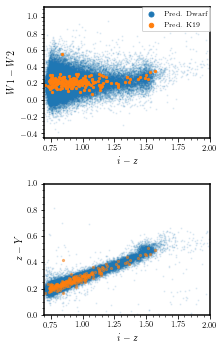

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)
ax1 = ax.scatter(dwarf_pred_des['IMAG_DERED']-dwarf_pred_des['ZMAG_DERED'],dwarf_pred_des['w1mpro'] - dwarf_pred_des['w2mpro'],
                  c='C0',s=1,label='Pred. Dwarf',rasterized=True)
ax2 = ax.scatter(des_pred_kiman['IMAG_DERED']-des_pred_kiman['ZMAG_DERED'],des_pred_kiman['w1mpro'] - des_pred_kiman['w2mpro'],
                c='C1',s=5,label='Pred. K19')

plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
leg.legendHandles[1]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(1.0)
plt.minorticks_on()
ax.set_xlim(0.70,2.0)

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.scatter(dwarf_pred_des['IMAG_DERED'] - dwarf_pred_des['ZMAG_DERED'],dwarf_pred_des['ZMAG_DERED'] - dwarf_pred_des['YMAG_DERED'],
                  c='C0',s=1,label='Pred. Dwarf',rasterized=True)
ax2 = ax_2.scatter(des_pred_kiman['IMAG_DERED'] - des_pred_kiman['ZMAG_DERED'],des_pred_kiman['ZMAG_DERED'] - des_pred_kiman['YMAG_DERED'],
                c='C1',s=5,label='Pred. K19')

plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')
plt.ylim(-0.2,2.0)
ax1.set_alpha(0.1)
ax2.set_alpha(0.5)

plt.minorticks_on()
ax_2.set_xlim(0.70,2.0)
ax_2.set_ylim(0.0,1.0)
plt.tight_layout()
#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_pred_parameterspace_kiman_retention.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
def conf_levels(x,y,bin_n):
  # Make a 2d normed histogram
  H,xedges,yedges=np.histogram2d(x,y,bins=bin_n,normed=True)
  norm=H.sum() # Find the norm of the sum
  # Set contour levels
  contour1=0.99
  contour2=0.95
  contour3=0.68

  # Set target levels as percentage of norm
  target1 = norm*contour1
  target2 = norm*contour2
  target3 = norm*contour3

  # Take histogram bin membership as proportional to Likelihood
  # This is true when data comes from a Markovian process
  def objective(limit, target):
      w = np.where(H>limit)
      count = H[w]
      return count.sum() - target

  # Find levels by summing histogram to objective
  #level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
  level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
  level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

  # Define the levels in an interable:
  levels=[level2,level3]
  return levels

In [ ]:
#def conf_levels_gauss(x,y):
  #Set up the 2D Gaussian:
#  X, Y = np.meshgrid(x, y)
#  sigma = 1.0
#  Z = mlab.bivariate_normal(X, Y, sigma, sigma, 0.0, 0.0)
#  #Get Z values for contours 1, 2, and 3 sigma away from peak:
#  sig_1 = mlab.bivariate_normal(0, 1 * sigma, sigma, sigma, 0.0, 0.0)
#  sig_2 = mlab.bivariate_normal(0, 2 * sigma, sigma, sigma, 0.0, 0.0)
#  sig_3 = mlab.bivariate_normal(0, 3 * sigma, sigma, sigma, 0.0, 0.0)
#  conf_levels = [sig_1,sig_2,sig_3]
#  return conf_levels

In [ ]:
levels_1 = conf_levels(dwarf_pred_des['IMAG_DERED']-dwarf_pred_des['ZMAG_DERED'],dwarf_pred_des['w1mpro'] - dwarf_pred_des['w2mpro'],bin_n=20)
levels_2 = conf_levels(des_pred_kiman['IMAG_DERED']-des_pred_kiman['ZMAG_DERED'],des_pred_kiman['w1mpro'] - des_pred_kiman['w2mpro'],bin_n=10)

In [ ]:
levels_2

[2.1576053928755456, 7.551618875059472]

In [ ]:
def gauss_levels(x,y):
  x,y = x.values,y.values
  objects = [[a,b] for a,b in zip(x,y)] 
  obj_arr = np.array(objects)

  xmin = x.min()
  xmax = x.max()
  ymin = y.min()
  ymax = y.max()

  X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = np.vstack([X.ravel(), Y.ravel()])
  #values = np.vstack([m1, m2])
  kernel = stats.gaussian_kde(obj_arr.T)
  Z = np.reshape(kernel(positions).T, X.shape)
  return X,Y,Z

In [ ]:
X1,Y1,Z1 = gauss_levels(dwarf_pred_des['IMAG_DERED']-dwarf_pred_des['ZMAG_DERED'],dwarf_pred_des['w1mpro'] - dwarf_pred_des['w2mpro'])
X2,Y2,Z2 = gauss_levels(des_pred_kiman['IMAG_DERED']-des_pred_kiman['ZMAG_DERED'],des_pred_kiman['w1mpro'] - des_pred_kiman['w2mpro'])

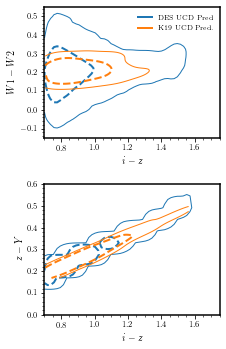

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)

X1,Y1,Z1 = gauss_levels(dwarf_pred_des['IMAG_DERED']-dwarf_pred_des['ZMAG_DERED'],dwarf_pred_des['w1mpro'] - dwarf_pred_des['w2mpro'])
X2,Y2,Z2 = gauss_levels(des_pred_kiman['IMAG_DERED']-des_pred_kiman['ZMAG_DERED'],des_pred_kiman['w1mpro'] - des_pred_kiman['w2mpro'])

ax1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
ax.set_xlim(0.70,1.75)
ax.set_ylim(-0.15,0.55)
plt.minorticks_on()

X1,Y1,Z1 = gauss_levels(dwarf_pred_des['IMAG_DERED']-dwarf_pred_des['ZMAG_DERED'],dwarf_pred_des['ZMAG_DERED'] - dwarf_pred_des['YMAG_DERED'])
X2,Y2,Z2 = gauss_levels(des_pred_kiman['IMAG_DERED']-des_pred_kiman['ZMAG_DERED'],des_pred_kiman['ZMAG_DERED'] - des_pred_kiman['YMAG_DERED'])

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax_2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)

plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'DES UCD Pred')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'K19 UCD Pred.')
ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
ax_2.set_xlim(0.70,1.75)
ax_2.set_ylim(0.0,0.6)
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_pred_parameterspace_kiman_retention_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

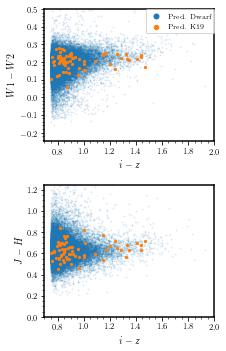

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)
ax1 = ax.scatter(dwarf_pred_smss['i_psf']-dwarf_pred_smss['z_psf'],dwarf_pred_smss['w1mpro'] - dwarf_pred_smss['w2mpro'],
                  c='C0',s=1,label='Pred. Dwarf',rasterized=True)
ax2 = ax.scatter(smss_pred_kiman['i_psf']-smss_pred_kiman['z_psf'],smss_pred_kiman['w1mpro'] - smss_pred_kiman['w2mpro'],
                c='C1',s=5,label='Pred. K19')

plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
leg.legendHandles[1]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(1.0)
ax.minorticks_on()
ax.set_xlim(0.70,2.0)
ax.set_ylim(-0.25,0.50)


ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.scatter(dwarf_pred_smss['i_psf'] - dwarf_pred_smss['z_psf'],dwarf_pred_smss['j_m'] - dwarf_pred_smss['h_m'],
                  c='C0',s=1,label='Pred. Dwarf',rasterized=True)
ax2 = ax_2.scatter(smss_pred_kiman['i_psf'] - smss_pred_kiman['z_psf'],smss_pred_kiman['j_m'] - smss_pred_kiman['h_m'],
                c='C1',s=5,label='Pred. K19')

plt.xlabel('$i - z$')
plt.ylabel('$J - H$')
plt.ylim(-0.2,2.0)
ax1.set_alpha(0.1)
ax2.set_alpha(1.0)

ax_2.minorticks_on()
ax_2.set_xlim(0.70,2.0)
ax_2.set_ylim(0.0,1.25)
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_pred_parameterspace_kiman_retention.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
levels_1 = conf_levels(dwarf_pred_smss['i_psf']-dwarf_pred_smss['z_psf'],dwarf_pred_smss['j_m'] - dwarf_pred_smss['h_m'],bin_n = 15)
levels_2 = conf_levels(smss_pred_kiman['i_psf']-smss_pred_kiman['z_psf'],smss_pred_kiman['j_m'] - smss_pred_kiman['h_m'],bin_n = 3)
print(levels_1)
print(levels_2)

[0.5264970422530804, 9.056172015957376]
[0.9578838175271233, 3.352593361344414]


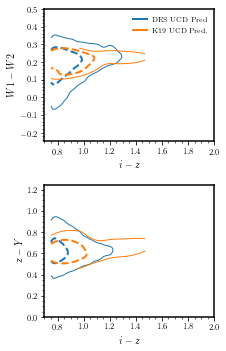

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)

X1,Y1,Z1 = gauss_levels(dwarf_pred_smss['i_psf']-dwarf_pred_smss['z_psf'],dwarf_pred_smss['w1mpro'] - dwarf_pred_smss['w2mpro'])
X2,Y2,Z2 = gauss_levels(smss_pred_kiman['i_psf']-smss_pred_kiman['z_psf'],smss_pred_kiman['w1mpro'] - smss_pred_kiman['w2mpro'])
levels_1 = conf_levels(dwarf_pred_smss['i_psf']-dwarf_pred_smss['z_psf'],dwarf_pred_smss['w1mpro'] - dwarf_pred_smss['w2mpro'],bin_n = 10)
levels_2 = conf_levels(smss_pred_kiman['i_psf']-smss_pred_kiman['z_psf'],smss_pred_kiman['w1mpro'] - smss_pred_kiman['w2mpro'],bin_n = 3)

ax1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
ax.set_xlim(0.70,2.0)
ax.set_ylim(-0.25,0.50)
plt.minorticks_on()

X1,Y1,Z1 = gauss_levels(dwarf_pred_smss['i_psf'] - dwarf_pred_smss['z_psf'],dwarf_pred_smss['j_m'] - dwarf_pred_smss['h_m'])
X2,Y2,Z2 = gauss_levels(smss_pred_kiman['i_psf'] - smss_pred_kiman['z_psf'],smss_pred_kiman['j_m'] - smss_pred_kiman['h_m'])
levels_1 = conf_levels(dwarf_pred_smss['i_psf']-dwarf_pred_smss['z_psf'],dwarf_pred_smss['j_m'] - dwarf_pred_smss['h_m'],bin_n=10)
levels_2 = conf_levels(smss_pred_kiman['i_psf']-smss_pred_kiman['z_psf'],smss_pred_kiman['j_m'] - smss_pred_kiman['h_m'],bin_n=5)

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax_2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax_2.set_xlim(0.70,2.0)
ax_2.set_ylim(0.0,1.25)
plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'DES UCD Pred')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'K19 UCD Pred.')
ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_pred_parameterspace_kiman_retention_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
# trying to see if the predictions match the color paramter space for i - z v. w1 - w2 and i -z v. z - Y
percent = 0.95
lm = des_preds[des_preds['keras_pred_dwarf'] >= percent]
print('Pr(Dwarfs) > %.2f:' % percent,len(lm))

hm = des_preds[des_preds['keras_pred_giant'] > percent]
print('Pr(Giant)> %.2f:' % percent,len(hm))

gal = des_preds[des_preds['keras_pred_galaxy'] > percent]
print('Pr(Galaxy) > %.2f:' % percent,len(gal))

qso = des_preds[des_preds['keras_pred_qso'] > percent]
print('Pr(QSO) > > %.2f:' % percent,len(qso))

Pr(Dwarfs) > 0.95: 81672
Pr(Giant)> 0.95: 1158
Pr(Galaxy) > 0.95: 124869
Pr(QSO) > > 0.95: 93


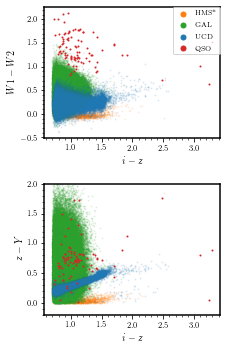

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)
ax4 = ax.scatter(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['w1mpro'] - hm['w2mpro'],
                  c='C1',s=1,label='HMS*')
ax2 = ax.scatter(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['w1mpro'] - gal['w2mpro'],
                c='C2',s=1,label='GAL',rasterized=True)
ax1 = ax.scatter(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['w1mpro'] - lm['w2mpro'],
                c='C0',s=1,label='UCD',rasterized=True)
ax3 = ax.scatter(qso['IMAG_DERED']-qso['ZMAG_DERED'],qso['w1mpro'] - qso['w2mpro'],
                  c='C3',s=1,label='QSO')
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(0.1)
ax3.set_alpha(1.0)
ax4.set_alpha(0.1)
ax.minorticks_on()


ax_2 = plt.subplot(2,1,2)
ax4 = ax_2.scatter(hm['IMAG_DERED'] - hm['ZMAG_DERED'],hm['ZMAG_DERED'] - hm['YMAG_DERED'],
                  c='C1',s=1)
ax2=ax_2.scatter(gal['IMAG_DERED'] - gal['ZMAG_DERED'],gal['ZMAG_DERED'] - gal['YMAG_DERED'],
                c='C2',s=1,rasterized=True)
ax1=ax_2.scatter(lm['IMAG_DERED'] - lm['ZMAG_DERED'],lm['ZMAG_DERED'] - lm['YMAG_DERED'],
                c='C0',s=1,rasterized=True)
ax3 = ax_2.scatter(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['ZMAG_DERED'] - qso['YMAG_DERED'],
                  c='C3',s=1)
plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')
plt.ylim(-0.2,2.0)
ax1.set_alpha(0.1)
ax2.set_alpha(0.1)
ax3.set_alpha(1.0)
ax4.set_alpha(0.1)
ax_2.minorticks_on()

plt.tight_layout()
#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_pred_parameterspace_scatter.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
levels_1 = conf_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['ZMAG_DERED'] - lm['YMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['ZMAG_DERED'] - hm['YMAG_DERED'],bin_n = 10)
levels_3 = conf_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['ZMAG_DERED'] - gal['YMAG_DERED'],bin_n = 25)
levels_4 = conf_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['ZMAG_DERED'] - qso['YMAG_DERED'],bin_n = 3)

print(levels_1)
print(levels_2)
print(levels_3)
print(levels_4)

[0.803384330362241, 6.63849157193812]
[0.36119164414072435, 4.979284808488201]
[0.33637988027209925, 1.429292288208234]
[0.036751389668646973, 0.679900708877874]


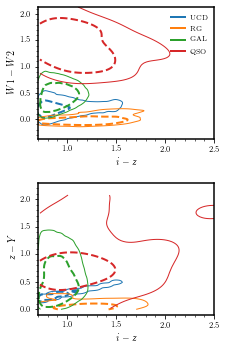

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)

X1,Y1,Z1 = gauss_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['w1mpro'] - lm['w2mpro'])
X2,Y2,Z2 = gauss_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['w1mpro'] - hm['w2mpro'])
X3,Y3,Z3 = gauss_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['w1mpro'] - gal['w2mpro'])
X4,Y4,Z4 = gauss_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['w1mpro'] - qso['w2mpro'])
levels_1 = conf_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['w1mpro'] - lm['w2mpro'],bin_n = 10)
levels_2 = conf_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['w1mpro'] - hm['w2mpro'],bin_n = 3)
levels_3 = conf_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['w1mpro'] - gal['w2mpro'],bin_n = 10)
levels_4 = conf_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['w1mpro'] - qso['w2mpro'],bin_n = 3)

ax1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3 = ax.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4 = ax.contour(X4,Y4,Z4, levels=levels_4, colors=['C3'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
ax.set_xlim(0.70,2.5)
#ax.set_ylim(0.0,2.0)
plt.minorticks_on()

X1,Y1,Z1 = gauss_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['ZMAG_DERED'] - lm['YMAG_DERED'])
X2,Y2,Z2 = gauss_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['ZMAG_DERED'] - hm['YMAG_DERED'])
X3,Y3,Z3 = gauss_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['ZMAG_DERED'] - gal['YMAG_DERED'])
X4,Y4,Z4 = gauss_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['ZMAG_DERED'] - qso['YMAG_DERED'])
levels_1 = conf_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['ZMAG_DERED'] - lm['YMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['ZMAG_DERED'] - hm['YMAG_DERED'],bin_n = 10)
levels_3 = conf_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['ZMAG_DERED'] - gal['YMAG_DERED'],bin_n = 25)
levels_4 = conf_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['ZMAG_DERED'] - qso['YMAG_DERED'],bin_n = 3)

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax_2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3 = ax_2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4 = ax_2.contour(X4,Y4,Z4, levels=levels_4, colors=['C3'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax_2.set_xlim(0.70,2.5)
ax_2.set_ylim(-0.1,2.3)
plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'RG')
ax.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'GAL')
ax.plot([0,0],[0,0], ls='solid', c='C3', lw=2, label=r'QSO')
ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_pred_parameterspace_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [20]:
# parameter space plots
other_pred_sm = smss_preds[smss_preds['keras_pred_dwarf'] < percent1]
print('Pr(Dwarf) < %.2f:' % percent1,len(other_pred_sm))

Pr(Dwarf) < 0.95: 302


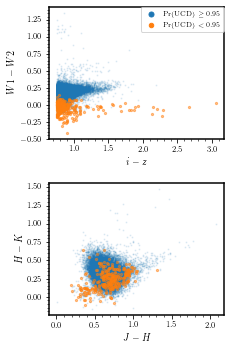

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)
ax1 = ax.scatter(dwarf_pred_smss['i_psf']-dwarf_pred_smss['z_psf'],dwarf_pred_smss['w1mpro'] - dwarf_pred_smss['w2mpro'],
                c='C0',s=1,label='Pr(UCD) $\geq 0.95$',rasterized=True)
ax4 = ax.scatter(other_pred_sm['i_psf']-other_pred_sm['z_psf'],other_pred_sm['w1mpro'] - other_pred_sm['w2mpro'],
                  c='C1',s=5,label='Pr(UCD) $< 0.95$')
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
leg.legendHandles[1]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax4.set_alpha(0.5)
plt.minorticks_on()


ax_2 = plt.subplot(2,1,2)
ax1=ax_2.scatter(dwarf_pred_smss['j_m'] - dwarf_pred_smss['h_m'],dwarf_pred_smss['h_m'] - dwarf_pred_smss['k_m'],
                c='C0',s=1,label='Pr(UCD) $\geq 0.95$',rasterized=True)
ax4 = ax_2.scatter(other_pred_sm['j_m'] - other_pred_sm['h_m'],other_pred_sm['h_m'] - other_pred_sm['k_m'],
                  c='C1',s=5,label='Pr(UCD) $< 0.95$')
plt.xlabel('$J - H$')
plt.ylabel('$H - K$')
ax1.set_alpha(0.1)
ax4.set_alpha(0.5)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_pred_parameterspace_scatter.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
levels_1 = conf_levels(dwarf_pred_smss['j_m'] - dwarf_pred_smss['h_m'],dwarf_pred_smss['h_m'] - dwarf_pred_smss['k_m'],bin_n = 15)
levels_2 = conf_levels(other_pred_sm['j_m'] - other_pred_sm['h_m'],other_pred_sm['h_m'] - other_pred_sm['k_m'],bin_n=10)
print(levels_1)
print(levels_2)

[0.4291890107707073, 4.829293441708838]
[0.3970333666840462, 2.779233566788324]


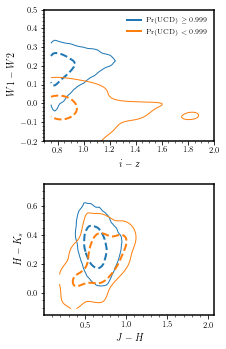

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)

X1,Y1,Z1 = gauss_levels(dwarf_pred_smss['i_psf']-dwarf_pred_smss['z_psf'],dwarf_pred_smss['w1mpro'] - dwarf_pred_smss['w2mpro'])
X2,Y2,Z2 = gauss_levels(other_pred_sm['i_psf']-other_pred_sm['z_psf'],other_pred_sm['w1mpro'] - other_pred_sm['w2mpro'])
levels_1 = conf_levels(dwarf_pred_smss['i_psf']-dwarf_pred_smss['z_psf'],dwarf_pred_smss['w1mpro'] - dwarf_pred_smss['w2mpro'],bin_n = 15)
levels_2 = conf_levels(other_pred_sm['i_psf']-other_pred_sm['z_psf'],other_pred_sm['w1mpro'] - other_pred_sm['w2mpro'],bin_n=10)

ax1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
ax.set_xlim(0.70,2.0)
ax.set_ylim(-0.2,0.50)
plt.minorticks_on()

X1,Y1,Z1 = gauss_levels(dwarf_pred_smss['j_m'] - dwarf_pred_smss['h_m'],dwarf_pred_smss['h_m'] - dwarf_pred_smss['k_m'])
X2,Y2,Z2 = gauss_levels(other_pred_sm['j_m'] - other_pred_sm['h_m'],other_pred_sm['h_m'] - other_pred_sm['k_m'])
levels_1 = conf_levels(dwarf_pred_smss['j_m'] - dwarf_pred_smss['h_m'],dwarf_pred_smss['h_m'] - dwarf_pred_smss['k_m'],bin_n = 15)
levels_2 = conf_levels(other_pred_sm['j_m'] - other_pred_sm['h_m'],other_pred_sm['h_m'] - other_pred_sm['k_m'],bin_n=10)

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax_2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
#ax_2.set_xlim(0.70,2.0)
ax_2.set_ylim(-0.15,0.75)
plt.xlabel('$J - H$')
plt.ylabel('$H - K_s$')

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'Pr(UCD) $\geq 0.999$')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'Pr(UCD) $< 0.999$')
ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_pred_parameterspace_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# UWE Cuts on predictions

In [38]:
mags_smss = ['i_psf', 'z_psf','j_m', 'h_m','k_m','w1mpro', 'w2mpro','phot_g_mean_mag']
mags_des = ['IMAG_DERED', 'ZMAG_DERED','YMAG_DERED','w1mpro','w2mpro','phot_g_mean_mag']

In [39]:
mags_smss_err = ['e_i_psf','e_z_psf','j_msigcom','h_msigcom','k_msigcom','w1sigmpro','w2sigmpro','phot_g_mean_flux_error']
mags_des_err = ['IMAG_DERED_ERR','ZMAG_DERED_ERR','YMAG_DERED_ERR','w1sigmpro','w2sigmpro','phot_g_mean_flux_error']

In [40]:
# getting distance errors:
smss_pospar['rest_sig'] = 0.5*(smss_pospar['B_rest_xa'] - smss_pospar['b_rest_x'])
des_pospar['rest_sig'] = 0.5*(des_pospar['B_rest_xa'] - des_pospar['b_rest_x'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
def abs_mag(d,m):
  return m - 5*np.log10(d) + 5

In [42]:
# getting absolute mags:
for mag in mags_smss:
  smss_pospar['M_'+mag] = abs_mag(smss_pospar['rest'],smss_pospar[mag])
for err in mags_smss_err:
  smss_pospar['M_'+err] = np.sqrt(smss_pospar[err]**2 + (5*smss_pospar['rest_sig']/smss_pospar['rest'])**2)

for mag in mags_des:
  des_pospar['M_'+mag] = abs_mag(des_pospar['rest'],des_pospar[mag])
for err in mags_des_err:
  des_pospar['M_'+err] = np.sqrt(des_pospar[err]**2 + (5*des_pospar['rest_sig']/des_pospar['rest'])**2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [43]:
def uwe_squared(chi2,obs):
    return chi2/(obs - 5)
    
def uwe_cut(gmag):
    return 1.2*max(1.4,np.exp(-0.2*(float(gmag) - 19.5)))

des_pospar['UWE'] = np.sqrt(uwe_squared(des_pospar['astrometric_chi2_al'],des_pospar['astrometric_n_obs_al']))
filtered = des_pospar[['COADD_OBJECT_ID','UWE','phot_g_mean_mag']]

s = [[col[0],col[1]] for index, col in filtered.T.iteritems() if col[1] < uwe_cut(col[2])]

s_df = pd.DataFrame(s,columns=['COADD_OBJECT_ID','UWE'])
print(s_df.shape)

des_dwarfs_clean = s_df.merge(des_pospar,on='COADD_OBJECT_ID',how='inner',suffixes=('','_dup'))
des_dwarfs_clean = des_dwarfs_clean.drop(des_dwarfs_clean.filter(regex='_dup').columns, axis=1)
print(des_dwarfs_clean.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(70614, 2)
(70614, 259)


In [44]:
smss_pospar['UWE'] = np.sqrt(uwe_squared(smss_pospar['astrometric_chi2_al'],smss_pospar['astrometric_n_obs_al']))
filtered = smss_pospar[['object_id','UWE','phot_g_mean_mag']]

s = [[col[0],col[1]] for index, col in filtered.T.iteritems() if col[1] < uwe_cut(col[2])]

s_df = pd.DataFrame(s,columns=['object_id','UWE'])
print(s_df.shape)

smss_dwarfs_clean = s_df.merge(smss_pospar,on='object_id',how='inner',suffixes=('','_dup'))
smss_dwarfs_clean = smss_dwarfs_clean.drop(smss_dwarfs_clean.filter(regex='_dup').columns, axis=1)
print(smss_dwarfs_clean.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(30828, 2)
(30828, 382)


In [48]:
smss_pospar = dwarf_pred_smss[dwarf_pred_smss['parallax'] > 0.0]
des_pospar = dwarf_pred_des[dwarf_pred_des['parallax'] > 0.0]
print(len(smss_pospar))
print(len(des_pospar))

32259
71953


In [49]:
dwarfs_nopar_des = dwarf_pred_des[(~dwarf_pred_des.COADD_OBJECT_ID.isin(des_pospar.COADD_OBJECT_ID))]
print(dwarfs_nopar_des.shape)

dwarfs_nopar_smss = dwarf_pred_smss[(~dwarf_pred_smss.object_id.isin(smss_pospar.object_id))]
print(dwarfs_nopar_smss.shape)

(9410, 245)
(3701, 364)


In [56]:
fp_smss = smss_dwarfs_clean[smss_dwarfs_clean['M_i_psf'] < 7.0]
fp_ratio = len(fp_smss)/len(smss_dwarfs_clean)
print('Actual FP ration for SMSS:',fp_ratio)

Actual FP ration for SMSS: 0.009698974957830543


In [57]:
def func(m,b,x):
  return m*x+b

x = np.linspace((des_dwarfs_clean['IMAG_DERED'] - des_dwarfs_clean['ZMAG_DERED']).min(),(des_dwarfs_clean['IMAG_DERED'] - des_dwarfs_clean['ZMAG_DERED']).max(),len(des_dwarfs_clean))
print(len(x))
params = [6,3.5]
y = func(params[0],params[1],x)

70614


In [58]:
fp_des = des_dwarfs_clean[(des_dwarfs_clean['M_IMAG_DERED'] < func(params[0],params[1],des_dwarfs_clean['IMAG_DERED'] - des_dwarfs_clean['ZMAG_DERED']))]
fp_ratio = len(fp_des)/len(des_dwarfs_clean)
print('Actual FP ration for DES:',fp_ratio)

Actual FP ration for DES: 0.004446710284079644


## Absolute Magnitude Plots

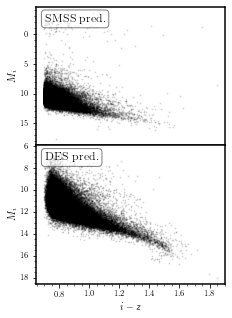

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

ax.scatter(smss_dwarfs_clean['i_psf'] - smss_dwarfs_clean['z_psf'],smss_dwarfs_clean['M_i_psf'],
            s=1,alpha=alpha,c='k',label='SMSS')
ax.set_ylabel('$M_i$')
ax.set_xlabel('$i - z$')
ax.invert_yaxis()
ax.minorticks_on()
#leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
#for l in leg.get_lines():
    #l.set_alpha(1)
ax.set_alpha(alpha)
#axis2.set_alpha(alpha)
#axis3.set_alpha(alpha)
textstr = 'SMSS pred.'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)


ax2.scatter(des_dwarfs_clean['IMAG_DERED'] - des_dwarfs_clean['ZMAG_DERED'],des_dwarfs_clean['M_IMAG_DERED'],
            s=1,c='k',alpha=alpha,label='DES')
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$M_i$')
ax2.invert_yaxis()
ax2.minorticks_on()

textstr = 'DES pred.'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/abs_mag_iz_preds_scatter.pdf')
plt.show()

In [ ]:
df = smss_dwarfs_clean[['phot_g_mean_mag','phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
df2 = des_dwarfs_clean[['phot_g_mean_mag','phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')

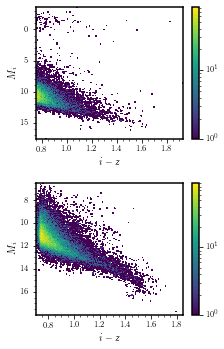

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
plt.subplots_adjust(hspace=0.0)
ax1 = plt.subplot(2,1,1)
plt.hist2d(smss_dwarfs_clean['i_psf'] - smss_dwarfs_clean['z_psf'],smss_dwarfs_clean['M_i_psf'],
           bins=250,norm=LogNorm(),rasterized=True)
plt.gca().set_xlabel('$i - z$')
plt.gca().set_ylabel('$M_i$')
plt.colorbar()
#plt.xlim(0.75,2.0)
plt.minorticks_on()
ax1.invert_yaxis()
#textstr = 'SMSS'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=15,
#        verticalalignment='top', bbox=props)

ax2 = plt.subplot(2,1,2)
plt.hist2d(des_dwarfs_clean['IMAG_DERED'] - des_dwarfs_clean['ZMAG_DERED'],des_dwarfs_clean['M_IMAG_DERED'],
           bins=250,norm=LogNorm(),rasterized=True)
plt.gca().set_xlabel('$i - z$')
plt.gca().set_ylabel('$M_i$')
plt.colorbar()
ax2.invert_yaxis()
#textstr = 'DES'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=15,
        #verticalalignment='top',ha='left',bbox=props)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/abs_mag_iz_preds_hist2d.pdf',dpi=300)
plt.show()

0.009698974957830543


# Fitting using Kiman et. al (2019) *Gaia* DR2 relationship:

$$ F(spt) = a(spt)^2 + b(spt) + c $$

Values in her table for $M_G$
$$a = -0.023,\ b = 1.1,\ c = 7.3$$
 
Values in her table for $G - RP$:
$$a = -0.0036,\ b = 0.11,\ c = 0.89$$ 

In [ ]:
spt1 = np.linspace(0,14,15)
spt1
#spt2 = np.linspace(6,14,9)
#spt2
#spt1

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [ ]:
def F(spt,a,b,c):
  return a*(spt)**2 + b*(spt) + c

In [ ]:
a = -0.0036
b = 0.11
c = 0.89

g_rp1 = F(spt1,a,b,c)
#g_rp2 = F(spt2,a,b,c)

In [ ]:
a = -0.023
b = 1.1
c = 7.3

g_Mg1= F(spt1,a,b,c)
#g_Mg2= F(spt2,a,b,c)

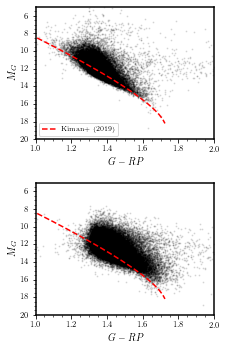

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

axis2 = ax.plot(g_rp1, g_Mg1, 'r--', label='Kiman+ (2019)')
#axis3 = ax.plot(g_rp2, g_Mg2, color='b', linewidth=3,ls='--', label='Kiman et al. (2019)')
axis1 = ax.scatter(smss_dwarfs_clean['phot_g_mean_mag'] - smss_dwarfs_clean['phot_rp_mean_mag'],smss_dwarfs_clean['M_phot_g_mean_mag'],
            s=1,alpha=alpha,c='k',rasterized=True)
ax.set_ylabel('$M_G$')
ax.set_xlabel('$G - RP$')
ax.set_ylim(5,20)
ax.set_xlim(1,2)
ax.invert_yaxis()
#ax.set_yticks(np.arange(5, 15, 5))
ax.minorticks_on()
ax.legend()
#leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
#for l in leg.get_lines():
    #l.set_alpha(1)
ax.set_alpha(alpha)
#axis2.set_alpha(alpha)
#axis3.set_alpha(alpha)
#textstr = 'SMSS pred.'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
#        verticalalignment='top', bbox=props)


axis3 = ax2.plot(g_rp1, g_Mg1, 'r--', label='Kiman et al. (2019)')
#axis4 = ax2.plot(g_rp2, g_Mg2, color='b', linewidth=3,ls='--', label='Kiman et al. (2019)')
ax2.scatter(des_dwarfs_clean['phot_g_mean_mag'] - des_dwarfs_clean['phot_rp_mean_mag'],des_dwarfs_clean['M_phot_g_mean_mag'],
            s=1,c='k',alpha=alpha,rasterized=True)
ax2.set_ylabel('$M_G$')#
ax2.set_xlabel('$G - RP$')
ax2.set_ylim(5,20)
ax2.set_xlim(1,2)
ax2.invert_yaxis()
#ax2.set_yticks(np.arange(5, 15, 5))
ax2.minorticks_on()

#textstr = 'DES pred.'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=15,
#        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/abs_mag_g_rp_preds_des_smss_scatter.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

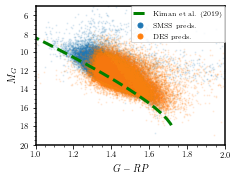

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(323)
#ax4 = fig.add_subplot(324)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

axis2 = ax.plot(g_rp1, g_Mg1, color='g', linewidth=3,ls='--', label='Kiman et al. (2019)')
#axis3 = ax.plot(g_rp2, g_Mg2, color='b', linewidth=3,ls='--', label='Kiman et al. (2019)')
axis1 = ax.scatter(smss_dwarfs_clean['phot_g_mean_mag'] - smss_dwarfs_clean['phot_rp_mean_mag'],smss_dwarfs_clean['M_phot_g_mean_mag'],
            s=1,c='C0',label='SMSS preds.')
axis3 = ax.scatter(des_dwarfs_clean['phot_g_mean_mag'] - des_dwarfs_clean['phot_rp_mean_mag'],des_dwarfs_clean['M_phot_g_mean_mag'],
            s=1,c='C1',label='DES preds.')
ax.set_ylabel('$M_G$')
ax.set_xlabel('$G - RP$')
ax.set_ylim(5,20)
ax.set_xlim(1,2)
ax.invert_yaxis()
ax.minorticks_on()
ax.legend()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis3.set_alpha(alpha)
#axis3.set_alpha(alpha)
#textstr = 'SMSS pred.'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)


#axis3 = ax2.plot(g_rp1, g_Mg1, color='r', linewidth=3,ls='--', label='Kiman et al. (2019)')
#axis4 = ax2.plot(g_rp2, g_Mg2, color='b', linewidth=3,ls='--', label='Kiman et al. (2019)')
#ax2.scatter(des_dwarfs_clean['phot_g_mean_mag'] - des_dwarfs_clean['phot_rp_mean_mag'],des_dwarfs_clean['M_phot_g_mean_mag'],
#            s=1,c='k',alpha=alpha)
#ax2.set_ylabel('$M_G$')#
#ax2.set_xlabel('$G - RP$')
#ax2.set_ylim(10,20)
#ax2.set_xlim(1,2)
#ax2.invert_yaxis()

#textstr = 'DES pred.'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=15,
#        verticalalignment='top', bbox=props)

#plt.tight_layout()
#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/abs_mag_iz_preds_des.pdf')
plt.show()

In [ ]:
df = smss_dwarfs_clean[['phot_g_mean_mag','phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
df2 = des_dwarfs_clean[['phot_g_mean_mag','phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')

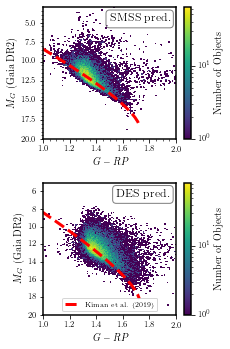

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

ax1 = plt.subplot(2,1,1)
plt.plot(g_rp1, g_Mg1, 'r--',lw=3, label='Kiman+ (2019)')
plt.hist2d(df['phot_g_mean_mag'] - df['phot_rp_mean_mag'],df['M_phot_g_mean_mag'],
            bins=350,norm=LogNorm(),rasterized=True)
ax1.set_ylabel('$M_G$ (Gaia DR2)')
ax1.set_xlabel('$G - RP$')
ax1.set_ylim(3,20)
ax1.set_xlim(1,2)
ax1.invert_yaxis()
ax1.minorticks_on()
plt.colorbar().set_label('Number of Objects')
#leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
#for l in leg.get_lines():
    #l.set_alpha(1)
#ax.set_alpha(alpha)
#axis2.set_alpha(alpha)
#axis3.set_alpha(alpha)
textstr = 'SMSS pred.'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax1.text(0.5, 0.95, textstr, transform=ax1.transAxes, fontsize=12,verticalalignment='top', bbox=props)

ax2 = plt.subplot(2,1,2)
plt.plot(g_rp1, g_Mg1, 'r--', lw=3,label='Kiman et al. (2019)')
plt.hist2d(df2['phot_g_mean_mag'] - df2['phot_rp_mean_mag'],df2['M_phot_g_mean_mag'],
            bins=350,norm=LogNorm(),rasterized=True)
ax2.set_ylabel('$M_G$ (Gaia DR2)')
ax2.set_xlabel('$G - RP$')
ax2.set_ylim(5,20)
ax2.set_xlim(1,2)
ax2.invert_yaxis()
plt.colorbar().set_label('Number of Objects')
ax2.legend(loc='lower center')
textstr = 'DES pred.'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax2.text(0.55, 0.95, textstr, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/abs_mag_g_rp_preds_des_smss_kimanfit_hist2d.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# Weighted polynomial fitting for $M_i$ v. $i - z$

In [ ]:
x_smss, y_smss = smss_dwarfs_clean['i_psf'] - smss_dwarfs_clean['z_psf'], smss_dwarfs_clean['M_i_psf']
x_des, y_des = des_dwarfs_clean['IMAG_DERED'] - des_dwarfs_clean['ZMAG_DERED'],des_dwarfs_clean['M_IMAG_DERED']

In [ ]:
w_smss = 1/smss_dwarfs_clean['M_e_i_psf']
np.shape(w_smss)

(30828,)

In [ ]:
w_smss.std()

4.7863802626690655

In [ ]:
x_test_smss = np.linspace(x_smss.min(),x_smss.max(),len(x_smss))
smss_fit = np.polyfit(x_smss,y_smss,deg=1
                      ,w=w_smss
                      )
smss_p = np.poly1d(smss_fit)

In [ ]:
smss_p

poly1d([5.36390094, 6.92920478])

In [ ]:
w_des = 1/des_dwarfs_clean['M_IMAG_DERED_ERR']

In [ ]:
w_des.std()

2.971393585439449

In [ ]:
x_test_des = np.linspace(x_des.min(),x_des.max(),len(x_des))
des_fit = np.polyfit(x_des,y_des,deg=1
                     ,w=w_des
                     )
des_p = np.poly1d(des_fit)

In [ ]:
des_p

poly1d([5.12892161, 7.43579228])

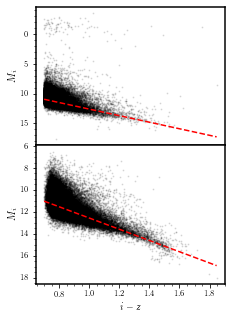

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

ax.plot(x_test_smss, smss_p(x_test_smss), 'r--',
         label='$a=%5.3f, b=%5.3f$' % tuple(smss_fit)
         )
ax.scatter(smss_dwarfs_clean['i_psf'] - smss_dwarfs_clean['z_psf'],smss_dwarfs_clean['M_i_psf'],
            s=1,alpha=alpha,c='k',rasterized=True)
ax.set_ylabel('$M_i$')
ax.set_xlabel('$i - z$')
ax.invert_yaxis()
ax.minorticks_on()
#leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
#for l in leg.get_lines():
    #l.set_alpha(1)
ax.set_alpha(alpha)
#axis2.set_alpha(alpha)
#axis3.set_alpha(alpha)
#ax.legend(prop={'size':12},loc='upper center')
#textstr = 'SMSS pred.'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
#        verticalalignment='top', bbox=props)

plt.plot(x_test_des, des_p(x_test_des), 'r--',
         label='$a=%5.3f, b=%5.3f$' % tuple(des_fit)
         )
ax2.scatter(des_dwarfs_clean['IMAG_DERED'] - des_dwarfs_clean['ZMAG_DERED'],des_dwarfs_clean['M_IMAG_DERED'],
            s=1,c='k',alpha=alpha,rasterized=True)
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$M_i$')
ax2.invert_yaxis()
ax2.minorticks_on()
#ax2.legend(prop={'size':12},loc='lower center')

#textstr = 'DES pred.'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
#        verticalalignment='top', bbox=props)

#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/abs_mag_iz_preds_scatter_linefit.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
df = smss_dwarfs_clean[['i_psf','z_psf','M_i_psf']].dropna(how='any')
df2 = des_dwarfs_clean[['IMAG_DERED','ZMAG_DERED','M_IMAG_DERED']].dropna(how='any')

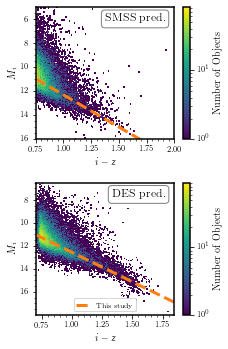

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

ax1 = plt.subplot(2,1,1)
ax1.plot(x_test_smss, smss_p(x_test_smss), c='C1',ls='--',lw=3
         )
plt.hist2d(df['i_psf'] - df['z_psf'],df['M_i_psf'],
            bins=250,norm=LogNorm(),rasterized=True)
ax1.set_ylabel('$M_i$')
ax1.set_xlabel('$i - z$')
ax1.set_ylim(5,16)
ax1.set_xlim(0.75,2)
ax1.invert_yaxis()
ax1.minorticks_on()
#ax1.legend(loc='upper center')
plt.colorbar().set_label('Number of Objects')
#leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
#for l in leg.get_lines():
    #l.set_alpha(1)
#ax.set_alpha(alpha)
#axis2.set_alpha(alpha)
#axis3.set_alpha(alpha)
textstr = 'SMSS pred.'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax1.text(0.5, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(2,1,2)
ax2.plot(x_test_des, des_p(x_test_des), c='C1',ls='--',lw=3,label='This study'
      
         )
plt.hist2d(df2['IMAG_DERED'] - df2['ZMAG_DERED'],df2['M_IMAG_DERED'],
            bins=250,norm=LogNorm(),rasterized=True)
ax2.set_ylabel('$M_i$')
ax2.set_xlabel('$i - z$')
#ax2.set_ylim(5,20)
#ax2.set_xlim(0.8,2)
ax2.invert_yaxis()
plt.colorbar().set_label('Number of Objects')
ax2.legend(loc='lower center')
ax2.minorticks_on()
textstr = 'DES pred.'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax2.text(0.55, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/abs_mag_i_z_preds_des_smss_fit_hist2d.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# *Gaia* DR 2 Distances

In [ ]:
kiman_dist = pd.read_csv('gdrive/My Drive/Colab Notebooks/analysis/kiman_gaiadr2_distances.csv')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


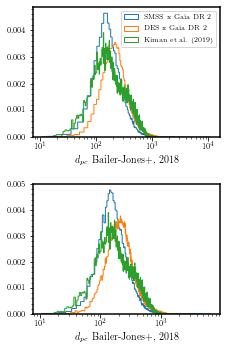

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
#plt.subplots_adjust(hspace=0.0)

ax1=plt.subplot(2,1,1)
plt.hist(smss_refset['rest'],histtype='step',bins=1000,density=True,label='SMSS x Gaia DR 2')
plt.hist(des_refset['rest'],histtype='step',bins=1000,density=True,label='DES x Gaia DR 2')
plt.hist(kiman_dist['rest'],histtype='step',bins=1000,density=True,label='Kiman et al. (2019)')
plt.xlabel('$d_{pc}$ Bailer-Jones+, 2018')
plt.legend(loc='upper right')
plt.minorticks_on()
plt.xscale('log')
#plt.show()
#textstr = ''
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)

ax2=plt.subplot(2,1,2)
plt.hist(smss_dwarfs_clean['rest'],histtype='step',bins=1000,density=True,label='SMSS preds')
plt.hist(des_dwarfs_clean['rest'],histtype='step',bins=1000,density=True,label='DES preds')
plt.hist(kiman_dist['rest'],histtype='step',bins=1000,density=True,label='Kiman et al. (2019)')
plt.xlabel('$d_{pc}$ Bailer-Jones+, 2018')
plt.minorticks_on()
plt.xscale('log')

#textstr = 'Pr(Dwarf) $> 0.95$'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=15,
#        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/gaia_dist_histograms.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

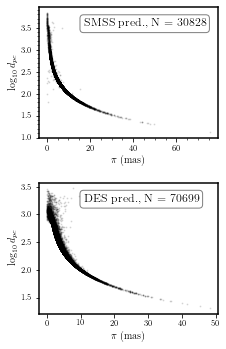

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(323)
#ax4 = fig.add_subplot(324)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

#axis2 = ax.plot(g_rp, g_Mg, color='r', linewidth=3,ls='--', label='Kiman et al. (2019)')
axis1 = ax.scatter(smss_dwarfs_clean['parallax'],np.log10(smss_dwarfs_clean['rest']),
            s=1,alpha=alpha,c='k')
ax.set_ylabel('$\log_{10} d_{pc}$')#
ax.set_xlabel('$\pi$ (mas)')
#ax.set_ylim(5,20)
#ax.set_xlim(1,2)
#ax.invert_yaxis()
ax.minorticks_on()
#ax.legend()
#leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
#for l in leg.get_lines():
    #l.set_alpha(1)
ax.set_alpha(alpha)
#axis2.set_alpha(alpha)
#axis3.set_alpha(alpha)
textstr = 'SMSS pred., N = {}'.format(len(smss_dwarfs_clean))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.25, 0.85, textstr, transform=ax.transAxes, fontsize=12,
         bbox=props)


#axis3 = ax2.plot(g_rp, g_Mg, color='r', linewidth=3,ls='--', label='Kiman et al. (2019)')
ax2.scatter(des_dwarfs_clean['parallax'],np.log10(des_dwarfs_clean['rest']),
            s=1,c='k',alpha=alpha)
ax2.set_ylabel('$\log_{10} d_{pc}$')#
ax2.set_xlabel('$\pi$ (mas)')
#ax2.legend()
#ax2.set_ylim(10,20)
#ax2.set_xlim(1,2)
#ax2.invert_yaxis()

textstr = 'DES pred., N = {}'.format(len(des_dwarfs_clean))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#
# place a text box in upper left in axes coords
ax2.text(0.25, 0.85, textstr, transform=ax2.transAxes, fontsize=12,
         bbox=props)

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/logdc_par_gaiadist.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

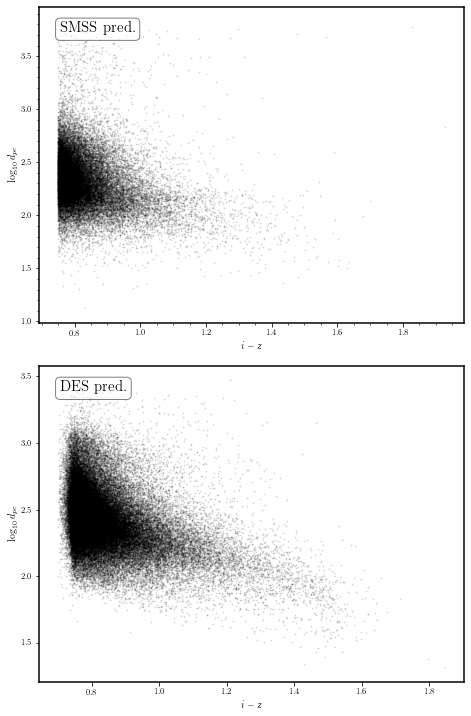

In [ ]:
fig = plt.figure(1,figsize=(2*3.4, 4*3.4*3/4.))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(323)
#ax4 = fig.add_subplot(324)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

#axis2 = ax.plot(g_rp, g_Mg, color='r', linewidth=3,ls='--', label='Kiman et al. (2019)')
axis1 = ax.scatter(smss_dwarfs_clean['i_psf'] - smss_dwarfs_clean['z_psf'],np.log10(smss_dwarfs_clean['rest']),
            s=1,alpha=alpha,c='k')
ax.set_ylabel('$\log_{10} d_{pc}$')#
ax.set_xlabel('$i - z$')
#ax.set_ylim(5,20)
#ax.set_xlim(1,2)
#ax.invert_yaxis()
ax.minorticks_on()
#ax.legend()
#leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
#for l in leg.get_lines():
    #l.set_alpha(1)
ax.set_alpha(alpha)
#axis2.set_alpha(alpha)
#axis3.set_alpha(alpha)
textstr = 'SMSS pred.'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)


#axis3 = ax2.plot(g_rp, g_Mg, color='r', linewidth=3,ls='--', label='Kiman et al. (2019)')
ax2.scatter(des_dwarfs_clean['IMAG_DERED'] - des_dwarfs_clean['ZMAG_DERED'], np.log10(des_dwarfs_clean['rest']),
            s=1,c='k',alpha=alpha)
ax2.set_ylabel('$\log_{10} d_{pc}$')#
ax2.set_xlabel('$i - z$')
#ax2.set_ylim(10,20)
#ax2.set_xlim(1,2)
#ax2.invert_yaxis()

textstr = 'DES pred.'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.tight_layout()
#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/abs_mag_iz_preds_des.pdf')
plt.show()

# Calculating Absolute Magnitudes

Getting "new" dwarfs, dwarfs without parallax, and absolute magnitudes.

In [59]:
near_dwarfs_smss = dwarf_pred_smss[dwarf_pred_smss['rest'] < 100]
near_dwarfs_des = dwarf_pred_des[dwarf_pred_des['rest'] < 100]
print(len(near_dwarfs_smss))
print(len(near_dwarfs_des))

2869
2352


In [60]:
# dwarfs not in training set with or without parallax
new_des_dwarfs = dwarf_pred_des[(~dwarf_pred_des.COADD_OBJECT_ID.isin(des_tset.COADD_OBJECT_ID))]
print(new_des_dwarfs.shape)

new_des_pospar = new_des_dwarfs[new_des_dwarfs['parallax'] > 0.0]
new_des_nopospoar = new_des_dwarfs[(~new_des_dwarfs.COADD_OBJECT_ID.isin(new_des_pospar.COADD_OBJECT_ID))]
print('Non-tset dwarfs with positive parallax:',new_des_pospar.shape)
print('Non-tset dwarfs without parallax:',new_des_nopospoar.shape)

(19403, 245)
Non-tset dwarfs with positive parallax: (9997, 245)
Non-tset dwarfs without parallax: (9406, 245)


In [61]:
# dwarfs not in training set with or without parallax
new_smss_dwarfs = dwarf_pred_smss[(~dwarf_pred_smss.object_id.isin(smss_tset.object_id))]
print(new_smss_dwarfs.shape)

new_smss_pospar = new_smss_dwarfs[new_smss_dwarfs['parallax'] > 0.0]
new_smss_nopospoar = new_smss_dwarfs[(~new_smss_dwarfs.object_id.isin(new_smss_pospar.object_id))]
print('Non-tset dwarfs with positive parallax:',new_smss_pospar.shape)
print('Non-tset dwarfs without parallax:',new_smss_nopospoar.shape)

(7339, 364)
Non-tset dwarfs with positive parallax: (3638, 364)
Non-tset dwarfs without parallax: (3701, 364)


In [62]:
# getting absolute mags:
for mag in mags_smss:
  new_smss_pospar['M_'+mag] = abs_mag(new_smss_pospar['rest'],new_smss_pospar[mag])

for mag in mags_des:
  new_des_pospar['M_'+mag] = abs_mag(new_des_pospar['rest'],new_des_pospar[mag])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
# getting absolute mags:
for mag in mags_smss:
  near_dwarfs_smss['M_'+mag] = abs_mag(near_dwarfs_smss['rest'],near_dwarfs_smss[mag])

for mag in mags_des:
  near_dwarfs_des['M_'+mag] = abs_mag(near_dwarfs_des['rest'],near_dwarfs_des[mag])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# DES absolute magnitude-color plots:

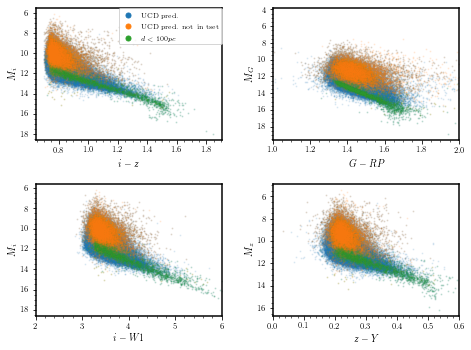

In [ ]:
fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

alpha = 0.1

imag = 'IMAG_DERED'
zmag = 'ZMAG_DERED'
ymag = 'YMAG_DERED'
gmag = 'phot_g_mean_mag'
w1mag = 'w1mpro'
w2mag = 'w2mpro'

axis1=ax.scatter(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_IMAG_DERED'],
            s=1,c='C0',label='UCD pred.',rasterized=True)
axis2=ax.scatter(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_IMAG_DERED'],
            s=1,c='C1',label='UCD pred. not in tset',rasterized=True)
axis3=ax.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_IMAG_DERED'],
            s=1,c='C2',label='$d < 100pc$')
ax.set_xlabel('$i - z$')
ax.set_ylabel('$M_i$')
ax.invert_yaxis()
ax.minorticks_on()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis2.set_alpha(alpha)
axis3.set_alpha(alpha)


ax2.scatter(des_dwarfs_clean[gmag] - des_dwarfs_clean['phot_rp_mean_mag'],des_dwarfs_clean['M_phot_g_mean_mag'],
            s=1,c='C0',alpha=alpha,rasterized=True)
ax2.scatter(new_des_pospar[gmag]-new_des_pospar['phot_rp_mean_mag'],new_des_pospar['M_phot_g_mean_mag'],
            s=1,c='C1',alpha=alpha,rasterized=True)
ax2.scatter(near_dwarfs_des[gmag] - near_dwarfs_des['phot_rp_mean_mag'],near_dwarfs_des['M_phot_g_mean_mag'],
            s=1,c='C2',alpha=alpha)
ax2.set_xlabel('$G - RP$')
ax2.set_ylabel('$M_G$')
ax2.invert_yaxis()
ax2.set_xlim(1.0,2.0)
ax2.minorticks_on()

ax3.scatter(des_dwarfs_clean[imag] - des_dwarfs_clean[w1mag],des_dwarfs_clean['M_IMAG_DERED'],
           s=1,c='C0',alpha=alpha,rasterized=True)
ax3.scatter(new_des_pospar[imag]-new_des_pospar[w1mag],new_des_pospar['M_IMAG_DERED'],
            s=1,c='C1',alpha=alpha,rasterized=True)
ax3.scatter(near_dwarfs_des[imag] - near_dwarfs_des[w1mag],near_dwarfs_des['M_IMAG_DERED'],
           s=1,c='C2',alpha=alpha)
ax3.set_xlabel('$i - W1$')
ax3.set_ylabel('$M_i$')
ax3.invert_yaxis()
ax3.set_xlim(2,6)
ax3.minorticks_on()

ax4.scatter(des_dwarfs_clean[zmag] - des_dwarfs_clean[ymag],des_dwarfs_clean['M_ZMAG_DERED'],
           s=1,c='C0',alpha=alpha,rasterized=True)
ax4.scatter(new_des_pospar[zmag]-new_des_pospar[ymag],new_des_pospar['M_ZMAG_DERED'],
            s=1,c='C1',alpha=alpha,rasterized=True)
ax4.scatter(near_dwarfs_des[zmag] - near_dwarfs_des[ymag],near_dwarfs_des['M_ZMAG_DERED'],
           s=1,c='C2',alpha=alpha)
ax4.set_xlabel('$z - Y$')
ax4.set_ylabel('$M_z$')
ax4.invert_yaxis()
ax4.set_xlim(0,0.6)
ax4.minorticks_on()

plt.tight_layout()
#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_abs_mag_preds_des_new.pdf',dpi = 300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
imag = 'IMAG_DERED'
zmag = 'ZMAG_DERED'
ymag = 'YMAG_DERED'
gmag = 'phot_g_mean_mag'
w1mag = 'w1mpro'
w2mag = 'w2mpro'

#df = des_dwarfs_clean[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
#df2 = new_des_pospar[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
#df3 = near_dwarfs_des[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')

levels_1 = conf_levels(des_dwarfs_clean[zmag] - des_dwarfs_clean[ymag],des_dwarfs_clean['M_ZMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[zmag]-new_des_pospar[ymag],new_des_pospar['M_ZMAG_DERED'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_des[zmag] - near_dwarfs_des[ymag],near_dwarfs_des['M_ZMAG_DERED'],bin_n = 25)

print(levels_1)
print(levels_2)
print(levels_3)

[0.13223496672834076, 0.6819270364559831]
[0.14439967701278078, 1.3140370608110203]
[0.260456717523663, 1.736378116829559]


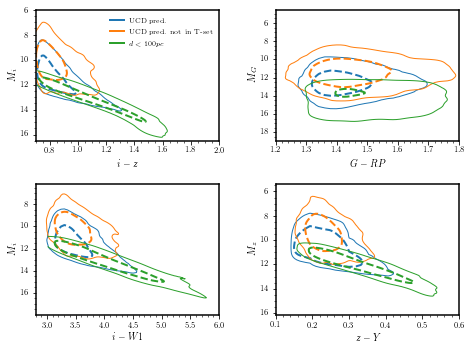

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))

ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

imag = 'IMAG_DERED'
zmag = 'ZMAG_DERED'
ymag = 'YMAG_DERED'
gmag = 'phot_g_mean_mag'
w1mag = 'w1mpro'
w2mag = 'w2mpro'

# ax plot
X1,Y1,Z1 = gauss_levels(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_IMAG_DERED'])
X2,Y2,Z2 = gauss_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_IMAG_DERED'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_IMAG_DERED'])
levels_1 = conf_levels(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_IMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_IMAG_DERED'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_IMAG_DERED'],bin_n = 25)

axis1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax.set_xlabel('$i - z$')
ax.set_ylabel('$M_i$')
ax.set_xlim(0.70,2.0)
ax.set_ylim(6,16.5)
ax.invert_yaxis()
ax.minorticks_on()

#ax2
X1,Y1,Z1 = gauss_levels((des_dwarfs_clean[gmag] - des_dwarfs_clean['phot_rp_mean_mag']).dropna(how='any'),des_dwarfs_clean['M_phot_g_mean_mag'].dropna(how='any'))
X2,Y2,Z2 = gauss_levels((new_des_pospar[gmag]-new_des_pospar['phot_rp_mean_mag']).dropna(how='any'),new_des_pospar['M_phot_g_mean_mag'].dropna(how='any'))
X3,Y3,Z3 = gauss_levels((near_dwarfs_des[gmag] - near_dwarfs_des['phot_rp_mean_mag']).dropna(how='any'),near_dwarfs_des['M_phot_g_mean_mag'].dropna(how='any'))

# need these df's because gaia photometry contains nans, and the level's function np.histogram doesn't account for nans.
df = des_dwarfs_clean[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
df2 = new_des_pospar[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
df3 = near_dwarfs_des[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')

levels_1 = conf_levels(df[gmag] - df['phot_rp_mean_mag'],df['M_phot_g_mean_mag'],bin_n = 25)
levels_2 = conf_levels(df2[gmag]-df2['phot_rp_mean_mag'],df2['M_phot_g_mean_mag'],bin_n = 25)
levels_3 = conf_levels(df3[gmag] - df3['phot_rp_mean_mag'],df3['M_phot_g_mean_mag'],bin_n = 25)

axis1 = ax2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2.set_xlabel('$G - RP$')
ax2.set_ylabel('$M_G$')
ax2.invert_yaxis()
ax2.set_xlim(1.2,1.8)
#ax2.set_ylim(bottom=8)
ax2.minorticks_on()

#ax3
X1,Y1,Z1 = gauss_levels(des_dwarfs_clean[imag] - des_dwarfs_clean[w1mag],des_dwarfs_clean['M_IMAG_DERED'])
X2,Y2,Z2 = gauss_levels(new_des_pospar[imag]-new_des_pospar[w1mag],new_des_pospar['M_IMAG_DERED'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_des[imag] - near_dwarfs_des[w1mag],near_dwarfs_des['M_IMAG_DERED'])
levels_1 = conf_levels(des_dwarfs_clean[imag] - des_dwarfs_clean[w1mag],des_dwarfs_clean['M_IMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[imag]-new_des_pospar[w1mag],new_des_pospar['M_IMAG_DERED'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_des[imag] - near_dwarfs_des[w1mag],near_dwarfs_des['M_IMAG_DERED'],bin_n = 25)

axis1 = ax3.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax3.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax3.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3.set_xlabel('$i - W1$')
ax3.set_ylabel('$M_i$')
ax3.invert_yaxis()
ax3.set_xlim(2.8,6)
ax3.minorticks_on()

#ax4
X1,Y1,Z1 = gauss_levels(des_dwarfs_clean[zmag] - des_dwarfs_clean[ymag],des_dwarfs_clean['M_ZMAG_DERED'])
X2,Y2,Z2 = gauss_levels(new_des_pospar[zmag]-new_des_pospar[ymag],new_des_pospar['M_ZMAG_DERED'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_des[zmag] - near_dwarfs_des[ymag],near_dwarfs_des['M_ZMAG_DERED'])
levels_1 = conf_levels(des_dwarfs_clean[zmag] - des_dwarfs_clean[ymag],des_dwarfs_clean['M_ZMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[zmag]-new_des_pospar[ymag],new_des_pospar['M_ZMAG_DERED'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_des[zmag] - near_dwarfs_des[ymag],near_dwarfs_des['M_ZMAG_DERED'],bin_n = 25)

axis1 = ax4.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax4.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax4.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4.set_xlabel('$z - Y$')
ax4.set_ylabel('$M_z$')
ax4.invert_yaxis()
ax4.set_xlim(0.1,0.6)
ax4.minorticks_on()

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD pred.')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'UCD pred. not in T-set')
ax.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'$d < 100pc$')

ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_abs_mag_preds_des_new_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

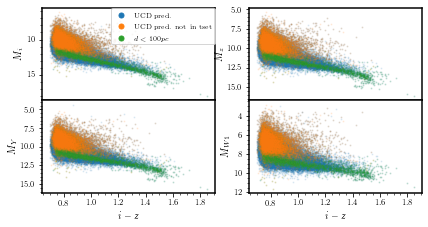

In [ ]:
fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

imag = 'IMAG_DERED'
zmag = 'ZMAG_DERED'
ymag = 'YMAG_DERED'
gmag = 'phot_g_mean_mag'
w1mag = 'w1mpro'
w2mag = 'w2mpro'

axis1=ax.scatter(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_IMAG_DERED'],
            s=1,c='C0',label='UCD pred.',rasterized=True)
axis2=ax.scatter(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_IMAG_DERED'],
            s=1,c='C1',label='UCD pred. not in tset',rasterized=True)
axis3=ax.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_IMAG_DERED'],
            s=1,c='C2',label='$d < 100pc$')
#ax.set_xscale('symlog')
ax.set_xlabel('$i - z$')
#plt.xlim(-25,125)
#plt.ylim(0.8,4.5)
ax.set_ylabel('$M_i$')
#ax.set_ylim(10,18)
ax.invert_yaxis()
ax.minorticks_on()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis2.set_alpha(alpha)
axis3.set_alpha(alpha)


ax2.scatter(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_ZMAG_DERED'],
            s=1,c='C0',alpha=alpha,rasterized=True)
ax2.scatter(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_ZMAG_DERED'],
            s=1,c='C1',alpha=alpha,rasterized=True)
ax2.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_ZMAG_DERED'],
            s=1,c='C2',alpha=alpha)
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$M_z$')
ax2.invert_yaxis()
ax2.minorticks_on()

ax3.scatter(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_YMAG_DERED'],
           s=1,c='C0',alpha=alpha,rasterized=True)
ax3.scatter(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_YMAG_DERED'],
            s=1,c='C1',alpha=alpha,rasterized=True)
ax3.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_YMAG_DERED'],
           s=1,c='C2',alpha=alpha)
ax3.set_xlabel('$i - z$')
ax3.set_ylabel('$M_Y$')
ax3.invert_yaxis()
ax3.minorticks_on()

ax4.scatter(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_w1mpro'],
           s=1,c='C0',alpha=alpha,rasterized=True)
ax4.scatter(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_w1mpro'],
            s=1,c='C1',alpha=alpha,rasterized=True)
ax4.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_w1mpro'],
           s=1,c='C2',alpha=alpha)
ax4.set_xlabel('$i - z$')
ax4.set_ylabel('$M_{W1}$')
#ax4.set_yticks(np.arange(5, 15, 5))
ax4.invert_yaxis()
#ax4.set_xlim(0,1.0)
ax4.minorticks_on()

#plt.tight_layout()
#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_abs_mag_iz_preds_des_new.pdf',dpi = 300,bbox_inches='tight',padding=0)
plt.show()

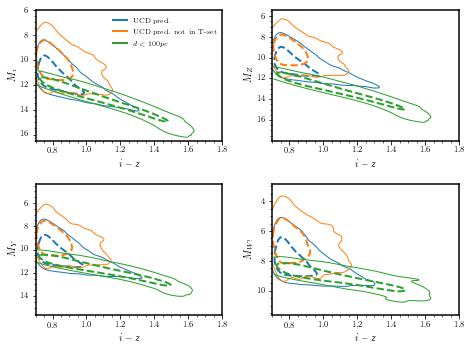

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))

ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plt.subplots_adjust(hspace=0.0)

imag = 'IMAG_DERED'
zmag = 'ZMAG_DERED'
ymag = 'YMAG_DERED'
gmag = 'phot_g_mean_mag'
w1mag = 'w1mpro'
w2mag = 'w2mpro'

# ax plot
X1,Y1,Z1 = gauss_levels(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_IMAG_DERED'])
X2,Y2,Z2 = gauss_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_IMAG_DERED'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_IMAG_DERED'])
levels_1 = conf_levels(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_IMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_IMAG_DERED'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_IMAG_DERED'],bin_n = 25)

axis1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax.set_xlabel('$i - z$')
ax.set_ylabel('$M_i$')
ax.set_xlim(0.70,1.8)
ax.set_ylim(6,16.5)
ax.invert_yaxis()
ax.minorticks_on()

#ax2
X1,Y1,Z1 = gauss_levels(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_ZMAG_DERED'])
X2,Y2,Z2 = gauss_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_ZMAG_DERED'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_IMAG_DERED'])

# need these df's because gaia photometry contains nans, and the level's function np.histogram doesn't account for nans.
#df = des_dwarfs_clean[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
#df2 = new_des_pospar[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
#df3 = near_dwarfs_des[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')

levels_1 = conf_levels(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_ZMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_ZMAG_DERED'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_IMAG_DERED'],bin_n = 25)

axis1 = ax2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$M_Z$')
ax2.invert_yaxis()
ax2.set_xlim(0.70,1.8)
ax2.minorticks_on()

#ax3
X1,Y1,Z1 = gauss_levels(des_dwarfs_clean[imag]-des_dwarfs_clean[zmag],des_dwarfs_clean['M_YMAG_DERED'])
X2,Y2,Z2 = gauss_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_YMAG_DERED'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_des[imag] - near_dwarfs_des[zmag],near_dwarfs_des['M_YMAG_DERED'])
levels_1 = conf_levels(des_dwarfs_clean[imag] - des_dwarfs_clean[zmag],des_dwarfs_clean['M_YMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_YMAG_DERED'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_des[imag] - near_dwarfs_des[zmag],near_dwarfs_des['M_YMAG_DERED'],bin_n = 25)

axis1 = ax3.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax3.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax3.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3.set_xlabel('$i - z$')
ax3.set_ylabel('$M_Y$')
ax3.invert_yaxis()
ax3.set_xlim(0.70,1.8)
ax3.minorticks_on()

#ax4
X1,Y1,Z1 = gauss_levels(des_dwarfs_clean[imag] - des_dwarfs_clean[zmag],des_dwarfs_clean['M_w1mpro'])
X2,Y2,Z2 = gauss_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_w1mpro'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_des[imag] - near_dwarfs_des[zmag],near_dwarfs_des['M_w1mpro'])
levels_1 = conf_levels(des_dwarfs_clean[imag] - des_dwarfs_clean[zmag],des_dwarfs_clean['M_w1mpro'],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar['M_w1mpro'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_des[imag] - near_dwarfs_des[zmag],near_dwarfs_des['M_w1mpro'],bin_n = 25)

axis1 = ax4.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax4.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax4.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4.set_xlabel('$i - z$')
ax4.set_ylabel('$M_{W!}$')
ax4.invert_yaxis()
ax4.set_xlim(0.70,1.8)
ax4.minorticks_on()

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD pred.')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'UCD pred. not in T-set')
ax.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'$d < 100pc$')

ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_abs_mag_iz_preds_des_new_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

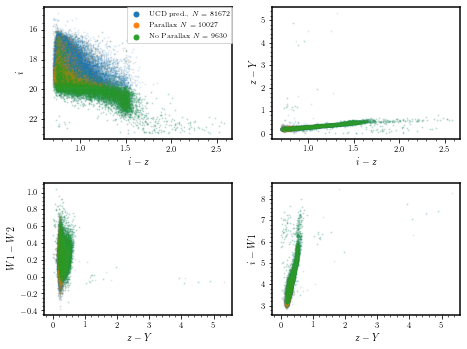

In [ ]:
fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
plt.subplot(2,2,1)

alpha = 0.1

ax0=plt.scatter(dwarf_pred_des[imag]-dwarf_pred_des[zmag],dwarf_pred_des[imag],
           s=1,c='C0',label='UCD pred., $N = {}$'.format(len(dwarf_pred_des)),rasterized=True)
ax1=plt.scatter(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar[imag],
           s=1,c='C1',label='Parallax $N = {}$'.format(len(new_des_pospar)),rasterized=True)
ax2=plt.scatter(new_des_nopospoar[imag]-new_des_nopospoar[zmag],new_des_nopospoar[imag],
           s=1,c='C2',label='No Parallax $N = {}$'.format(len(new_des_nopospoar)))
plt.xlabel('$i - z$')
plt.ylabel('$i$')
plt.minorticks_on()
plt.legend()
plt.gca().invert_yaxis()
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
ax0.set_alpha(alpha)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,2)

ax0=plt.scatter(dwarf_pred_des[imag]-dwarf_pred_des[zmag],dwarf_pred_des[zmag]-dwarf_pred_des[ymag],
           s=1,c='C0',rasterized=True)
ax1=plt.scatter(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar[zmag]-new_des_pospar[ymag],
           s=1,c='C1',rasterized=True)
ax2=plt.scatter(new_des_nopospoar[imag]-new_des_nopospoar[zmag],new_des_nopospoar[zmag]-new_des_nopospoar[ymag],
           s=1,c='C2')
plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')
plt.minorticks_on()
#plt.gca().invert_yaxis()
ax0.set_alpha(alpha)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,3)
ax0=plt.scatter(dwarf_pred_des[zmag]-dwarf_pred_des[ymag],dwarf_pred_des[w1mag]-dwarf_pred_des[w2mag],
           s=1,c='C0',rasterized=True)
ax1=plt.scatter(new_des_pospar[zmag]-new_des_pospar[ymag],new_des_pospar[w1mag]-new_des_pospar[w2mag],
           s=1,c='C1',rasterized=True)
ax2=plt.scatter(new_des_nopospoar[zmag]-new_des_nopospoar[ymag],new_des_nopospoar[w1mag]-new_des_nopospoar[w2mag],
           s=1,c='C2')
plt.xlabel('$z - Y$')
plt.ylabel('$W1 - W2$')
plt.minorticks_on()
#plt.legend()
#plt.gca().invert_yaxis()
ax0.set_alpha(alpha)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,4)
ax0=plt.scatter(dwarf_pred_des[zmag]-dwarf_pred_des[ymag],dwarf_pred_des[imag]-dwarf_pred_des[w1mag],
           s=1,c='C0',rasterized=True)
ax1=plt.scatter(new_des_pospar[zmag]-new_des_pospar[ymag],new_des_pospar[imag]-new_des_pospar[w1mag],
           s=1,c='C1',rasterized=True)
ax2=plt.scatter(dwarfs_nopar_des[zmag]-dwarfs_nopar_des[ymag],dwarfs_nopar_des[imag]-dwarfs_nopar_des[w1mag],
           s=1,c='C2')
plt.xlabel('$z - Y$')
plt.ylabel('$i - W1$')
plt.minorticks_on()
#plt.gca().invert_yaxis()
ax0.set_alpha(alpha)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_par_nopar_preds_new.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

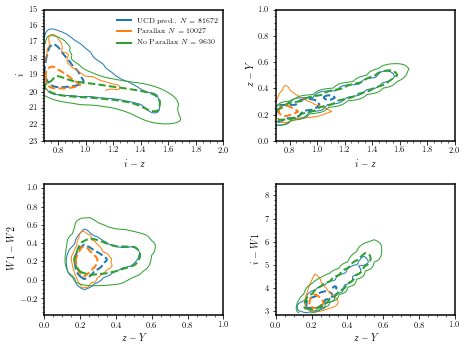

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))

ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

imag = 'IMAG_DERED'
zmag = 'ZMAG_DERED'
ymag = 'YMAG_DERED'
gmag = 'phot_g_mean_mag'
w1mag = 'w1mpro'
w2mag = 'w2mpro'

# ax plot
X1,Y1,Z1 = gauss_levels(dwarf_pred_des[imag]-dwarf_pred_des[zmag],dwarf_pred_des[imag])
X2,Y2,Z2 = gauss_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar[imag])
X3,Y3,Z3 = gauss_levels(new_des_nopospoar[imag]-new_des_nopospoar[zmag],new_des_nopospoar[imag])
levels_1 = conf_levels(dwarf_pred_des[imag]-dwarf_pred_des[zmag],dwarf_pred_des[imag],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar[imag],bin_n = 25)
levels_3 = conf_levels(new_des_nopospoar[imag]-new_des_nopospoar[zmag],new_des_nopospoar[imag],bin_n = 25)

axis1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax.set_xlabel('$i - z$')
ax.set_ylabel('$i$')
ax.set_xlim(0.70,2.0)
ax.set_ylim(15,23)
ax.invert_yaxis()
ax.minorticks_on()

#ax2
X1,Y1,Z1 = gauss_levels(dwarf_pred_des[imag]-dwarf_pred_des[zmag],dwarf_pred_des[zmag] - dwarf_pred_des[ymag])
X2,Y2,Z2 = gauss_levels(new_des_pospar[imag]-new_des_pospar[zmag],dwarf_pred_des[zmag] - dwarf_pred_des[ymag])
X3,Y3,Z3 = gauss_levels(new_des_nopospoar[imag]-new_des_nopospoar[zmag],new_des_nopospoar[zmag] - new_des_nopospoar[ymag])
levels_1 = conf_levels(dwarf_pred_des[imag]-dwarf_pred_des[zmag],dwarf_pred_des[zmag] - dwarf_pred_des[ymag],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[imag]-new_des_pospar[zmag],new_des_pospar[zmag] - new_des_pospar[ymag],bin_n = 25)
levels_3 = conf_levels(new_des_nopospoar[imag]-new_des_nopospoar[zmag],new_des_nopospoar[zmag] - new_des_nopospoar[ymag],bin_n = 25)

axis1 = ax2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$z - Y$')
#ax2.invert_yaxis()
ax2.set_xlim(0.70,2.0)
ax2.set_ylim(0.0,1.0)
ax2.minorticks_on()

#ax3
X1,Y1,Z1 = gauss_levels(dwarf_pred_des[zmag]-dwarf_pred_des[ymag],dwarf_pred_des[w1mag]-dwarf_pred_des[w2mag])
X2,Y2,Z2 = gauss_levels(new_des_pospar[zmag]-new_des_pospar[ymag],dwarf_pred_des[w1mag] - dwarf_pred_des[w2mag])
X3,Y3,Z3 = gauss_levels(new_des_nopospoar[zmag]-new_des_nopospoar[ymag],new_des_nopospoar[w1mag] - new_des_nopospoar[w2mag])
levels_1 = conf_levels(dwarf_pred_des[zmag]-dwarf_pred_des[ymag],dwarf_pred_des[w1mag] - dwarf_pred_des[w2mag],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[zmag]-new_des_pospar[ymag],new_des_pospar[w1mag] - new_des_pospar[w2mag],bin_n = 25)
levels_3 = conf_levels(new_des_nopospoar[zmag]-new_des_nopospoar[ymag],new_des_nopospoar[w1mag] - new_des_nopospoar[w2mag],bin_n = 25)

axis1 = ax3.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax3.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax3.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3.set_xlabel('$z - Y$')
ax3.set_ylabel('$W1 - W2$')
#ax3.invert_yaxis()
ax3.set_xlim(0,1.0)
ax3.minorticks_on()

#ax4
X1,Y1,Z1 = gauss_levels(dwarf_pred_des[zmag]-dwarf_pred_des[ymag],dwarf_pred_des[imag]-dwarf_pred_des[w1mag])
X2,Y2,Z2 = gauss_levels(new_des_pospar[zmag]-new_des_pospar[ymag],dwarf_pred_des[imag] - dwarf_pred_des[w1mag])
X3,Y3,Z3 = gauss_levels(new_des_nopospoar[zmag]-new_des_nopospoar[ymag],new_des_nopospoar[imag] - new_des_nopospoar[w1mag])
levels_1 = conf_levels(dwarf_pred_des[zmag]-dwarf_pred_des[ymag],dwarf_pred_des[imag] - dwarf_pred_des[w1mag],bin_n = 25)
levels_2 = conf_levels(new_des_pospar[zmag]-new_des_pospar[ymag],new_des_pospar[imag] - new_des_pospar[w1mag],bin_n = 25)
levels_3 = conf_levels(new_des_nopospoar[zmag]-new_des_nopospoar[ymag],new_des_nopospoar[imag] - new_des_nopospoar[w1mag],bin_n = 25)

axis1 = ax4.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax4.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax4.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4.set_xlabel('$z - Y$')
ax4.set_ylabel('$i - W1$')
#ax4.invert_yaxis()
ax4.set_xlim(0,1.0)
ax4.minorticks_on()

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD pred., $N = {}$'.format(len(dwarf_pred_des)))
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'Parallax $N = {}$'.format(len(new_des_pospar)))
ax.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'No Parallax $N = {}$'.format(len(new_des_nopospoar)))

ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_par_nopar_preds_new_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# SMSS absolute magnitude-color plots:

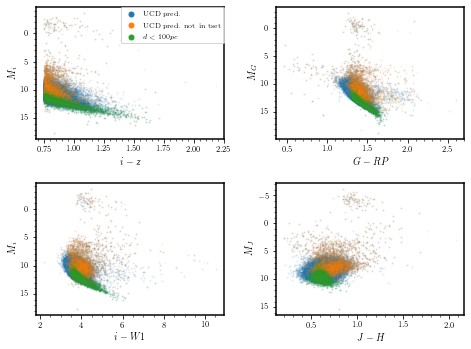

In [ ]:
fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)
plt.subplots_adjust(hspace=2.0)

alpha = 0.1

imag,zmag = 'i_psf','z_psf'
jmag,hmag,kmag = 'j_m','h_m','k_m'
gmag,rpmag = 'phot_g_mean_mag','phot_rp_mean_mag'
w1mag,w1mag = 'w1mpro','w2mpro'

axis1=ax.scatter(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_i_psf'],
            s=1,c='C0',label='UCD pred.',rasterized=True)
axis2=ax.scatter(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_i_psf'],
            s=1,c='C1',label='UCD pred. not in tset')
axis3=ax.scatter(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_i_psf'],
            s=1,c='C2',label='$d < 100pc$')
#ax.set_xscale('symlog')
ax.set_xlabel('$i - z$')
#plt.xlim(-25,125)
#plt.ylim(0.8,4.5)
ax.set_ylabel('$M_i$')
#ax.set_ylim(10,18)
ax.invert_yaxis()
ax.minorticks_on()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis2.set_alpha(alpha)
axis3.set_alpha(alpha)


ax2.scatter(smss_dwarfs_clean[gmag] - smss_dwarfs_clean[rpmag],smss_dwarfs_clean['M_phot_g_mean_mag'],
            s=1,c='C0',alpha=alpha,rasterized=True)
ax2.scatter(new_smss_pospar[gmag]-new_smss_pospar[rpmag],new_smss_pospar['M_phot_g_mean_mag'],
            s=1,c='C1',alpha=alpha)
ax2.scatter(near_dwarfs_smss[gmag] - near_dwarfs_smss[rpmag],near_dwarfs_smss['M_phot_g_mean_mag'],
            s=1,c='C2',alpha=alpha)
ax2.set_xlabel('$G - RP$')
ax2.set_ylabel('$M_G$')
ax2.invert_yaxis()
ax2.minorticks_on()

ax3.scatter(smss_dwarfs_clean[imag] - smss_dwarfs_clean[w1mag],smss_dwarfs_clean['M_i_psf'],
           s=1,c='C0',alpha=alpha,rasterized=True)
ax3.scatter(new_smss_pospar[imag]-new_smss_pospar[w1mag],new_smss_pospar['M_i_psf'],
            s=1,c='C1',alpha=alpha)
ax3.scatter(near_dwarfs_smss[imag] - near_dwarfs_smss[w1mag],near_dwarfs_smss['M_i_psf'],
           s=1,c='C2',alpha=alpha)
ax3.set_xlabel('$i - W1$')
ax3.set_ylabel('$M_i$')
ax3.invert_yaxis()
ax3.minorticks_on()

ax4.scatter(smss_dwarfs_clean[jmag] - smss_dwarfs_clean[hmag],smss_dwarfs_clean['M_j_m'],
           s=1,c='C0',alpha=alpha,rasterized=True)
ax4.scatter(new_smss_pospar[jmag]-new_smss_pospar[hmag],new_smss_pospar['M_j_m'],
            s=1,c='C1',alpha=alpha)
ax4.scatter(near_dwarfs_smss[jmag] - near_dwarfs_smss[hmag],near_dwarfs_smss['M_j_m'],
           s=1,c='C2',alpha=alpha)
ax4.set_xlabel('$J - H$')
ax4.set_ylabel('$M_{J}$')
ax4.invert_yaxis()
ax4.minorticks_on()

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_abs_mag_preds_new.pdf',dpi = 300,bbox_inches='tight',padding=0)
plt.show()

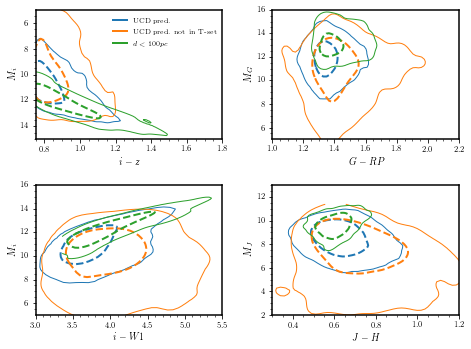

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))

ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

imag,zmag = 'i_psf','z_psf'
jmag,hmag,kmag = 'j_m','h_m','k_m'
gmag,rpmag = 'phot_g_mean_mag','phot_rp_mean_mag'
w1mag,w1mag = 'w1mpro','w2mpro'

# ax plot
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_i_psf'])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_i_psf'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_i_psf'])
levels_1 = conf_levels(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_i_psf'],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_i_psf'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_i_psf'],bin_n = 25)

axis1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax.set_xlabel('$i - z$')
ax.set_ylabel('$M_i$')
ax.set_xlim(0.75,1.8)
ax.set_ylim(5.0,15.0)
ax.invert_yaxis()
ax.minorticks_on()

#ax2
X1,Y1,Z1 = gauss_levels((smss_dwarfs_clean[gmag] - smss_dwarfs_clean['phot_rp_mean_mag']).dropna(how='any'),smss_dwarfs_clean['M_phot_g_mean_mag'].dropna(how='any'))
X2,Y2,Z2 = gauss_levels((new_smss_pospar[gmag]-new_smss_pospar['phot_rp_mean_mag']).dropna(how='any'),new_smss_pospar['M_phot_g_mean_mag'].dropna(how='any'))
X3,Y3,Z3 = gauss_levels((near_dwarfs_smss[gmag] - near_dwarfs_smss['phot_rp_mean_mag']).dropna(how='any'),near_dwarfs_smss['M_phot_g_mean_mag'].dropna(how='any'))

# need these df's because gaia photometry contains nans, and the level's function np.histogram doesn't account for nans.
df = smss_dwarfs_clean[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
df2 = new_smss_pospar[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
df3 = near_dwarfs_smss[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')

levels_1 = conf_levels(df[gmag] - df['phot_rp_mean_mag'],df['M_phot_g_mean_mag'],bin_n = 25)
levels_2 = conf_levels(df2[gmag]-df2['phot_rp_mean_mag'],df2['M_phot_g_mean_mag'],bin_n = 25)
levels_3 = conf_levels(df3[gmag] - df3['phot_rp_mean_mag'],df3['M_phot_g_mean_mag'],bin_n = 25)

axis1 = ax2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2.set_xlabel('$G - RP$')
ax2.set_ylabel('$M_G$')
ax2.invert_yaxis()
ax2.set_xlim(1.0,2.2)
ax2.set_ylim(5.0,16.0)
ax2.minorticks_on()

#ax3
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[imag] - smss_dwarfs_clean[w1mag],smss_dwarfs_clean['M_i_psf'])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[imag]-new_smss_pospar[w1mag],new_smss_pospar['M_i_psf'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_smss[imag] - near_dwarfs_smss[w1mag],near_dwarfs_smss['M_i_psf'])
levels_1 = conf_levels(smss_dwarfs_clean[imag] - smss_dwarfs_clean[w1mag],smss_dwarfs_clean['M_i_psf'],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[imag]-new_smss_pospar[w1mag],new_smss_pospar['M_i_psf'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_smss[imag] - near_dwarfs_smss[w1mag],near_dwarfs_smss['M_i_psf'],bin_n = 25)

axis1 = ax3.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax3.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax3.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3.set_xlabel('$i - W1$')
ax3.set_ylabel('$M_i$')
ax3.invert_yaxis()
ax3.set_xlim(3,5.5)
ax3.set_ylim(5.0,16.0)
ax3.minorticks_on()

#ax4
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[jmag] - smss_dwarfs_clean[hmag],smss_dwarfs_clean['M_j_m'])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[jmag]-new_smss_pospar[hmag],new_smss_pospar['M_j_m'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_smss[jmag] - near_dwarfs_smss[hmag],near_dwarfs_smss['M_j_m'])
levels_1 = conf_levels(smss_dwarfs_clean[jmag] - smss_dwarfs_clean[hmag],smss_dwarfs_clean['M_j_m'],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[jmag]-new_smss_pospar[hmag],new_smss_pospar['M_j_m'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_smss[jmag] - near_dwarfs_smss[hmag],near_dwarfs_smss['M_j_m'],bin_n = 25)

axis1 = ax4.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax4.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax4.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4.set_xlabel('$J - H$')
ax4.set_ylabel('$M_J$')
ax4.invert_yaxis()
ax4.set_xlim(0.3,1.2)
ax4.set_ylim(2.0,13)
ax4.minorticks_on()

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD pred.')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'UCD pred. not in T-set')
ax.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'$d < 100pc$')

ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_abs_mag_preds_new_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

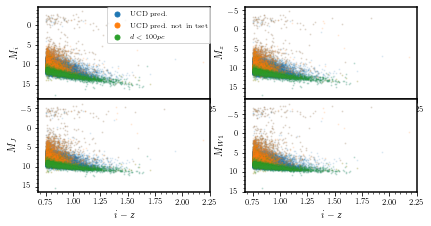

In [ ]:
fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
ax = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

imag,zmag = 'i_psf','z_psf'
jmag,hmag,kmag = 'j_m','h_m','k_m'
gmag,rpmag = 'phot_g_mean_mag','phot_rp_mean_mag'
w1mag,w1mag = 'w1mpro','w2mpro'

axis1=ax.scatter(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_i_psf'],
            s=1,c='C0',label='UCD pred.',rasterized=True)
axis2=ax.scatter(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_i_psf'],
            s=1,c='C1',label='UCD pred. not in tset')
axis3=ax.scatter(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_i_psf'],
            s=1,c='C2',label='$d < 100pc$')
#ax.set_xscale('symlog')
ax.set_xlabel('$i - z$')
#plt.xlim(-25,125)
#plt.ylim(0.8,4.5)
ax.set_ylabel('$M_i$')
#ax.set_ylim(10,18)
ax.invert_yaxis()
ax.minorticks_on()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis2.set_alpha(alpha)
axis3.set_alpha(alpha)


ax2.scatter(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_z_psf'],
            s=1,c='C0',alpha=alpha)
ax2.scatter(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_z_psf'],
            s=1,c='C1',alpha=alpha)
ax2.scatter(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_z_psf'],
            s=1,c='C2',alpha=alpha)
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$M_z$')
ax2.invert_yaxis()
ax2.minorticks_on()

ax3.scatter(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_j_m'],
           s=1,c='C0',alpha=alpha)
ax3.scatter(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_j_m'],
            s=1,c='C1',alpha=alpha)
ax3.scatter(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_j_m'],
           s=1,c='C2',alpha=alpha)
ax3.set_xlabel('$i - z$')
ax3.set_ylabel('$M_J$')
ax3.invert_yaxis()
ax3.minorticks_on()

ax4.scatter(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_w1mpro'],
           s=1,c='C0',alpha=alpha)
ax4.scatter(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_w1mpro'],
            s=1,c='C1',alpha=alpha)
ax4.scatter(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_w1mpro'],
           s=1,c='C2',alpha=alpha)
ax4.set_xlabel('$i - z$')
ax4.set_ylabel('$M_{W1}$')
ax4.invert_yaxis()
#ax4.set_xlim(0,1.0)
ax4.minorticks_on()

#plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_abs_mag_iz_preds_new.pdf',dpi = 300,bbox_inches='tight',padding=0)
plt.show()

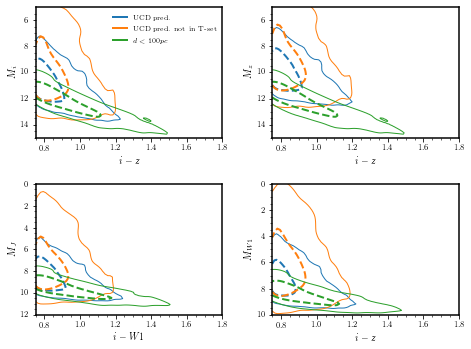

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))

ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

imag,zmag = 'i_psf','z_psf'
jmag,hmag,kmag = 'j_m','h_m','k_m'
gmag,rpmag = 'phot_g_mean_mag','phot_rp_mean_mag'
w1mag,w1mag = 'w1mpro','w2mpro'

# ax plot
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_i_psf'])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_i_psf'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_i_psf'])
levels_1 = conf_levels(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_i_psf'],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_i_psf'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss['M_i_psf'],bin_n = 25)

axis1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax.set_xlabel('$i - z$')
ax.set_ylabel('$M_i$')
ax.set_xlim(0.75,1.8)
ax.set_ylim(5.0,15.0)
ax.minorticks_on()
ax.invert_yaxis()

#ax2
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[imag] - smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_z_psf'])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_z_psf'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_smss[imag] - near_dwarfs_smss[zmag],near_dwarfs_smss['M_i_psf'])

levels_1 = conf_levels(smss_dwarfs_clean[imag] - smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_z_psf'],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_z_psf'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_smss[imag] - near_dwarfs_smss[zmag],near_dwarfs_smss['M_i_psf'],bin_n = 25)

axis1 = ax2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$M_z$')
ax2.set_xlim(0.75,1.8)
ax2.set_ylim(5.0,15.0)
ax2.minorticks_on()
ax2.invert_yaxis()

#ax3
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[imag] - smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_j_m'])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_j_m'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_smss[imag] - near_dwarfs_smss[zmag],near_dwarfs_smss['M_j_m'])
levels_1 = conf_levels(smss_dwarfs_clean[imag] - smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_j_m'],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_j_m'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_smss[imag] - near_dwarfs_smss[zmag],near_dwarfs_smss['M_j_m'],bin_n = 25)

axis1 = ax3.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax3.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax3.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3.set_xlabel('$i - W1$')
ax3.set_ylabel('$M_J$')
ax3.set_xlim(0.75,1.8)
ax3.set_ylim(0.0,12.0)
ax3.minorticks_on()
ax3.invert_yaxis()

#ax4
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[imag] - smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_w1mpro'])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_w1mpro'])
X3,Y3,Z3 = gauss_levels(near_dwarfs_smss[imag] - near_dwarfs_smss[zmag],near_dwarfs_smss['M_w1mpro'])
levels_1 = conf_levels(smss_dwarfs_clean[imag] - smss_dwarfs_clean[zmag],smss_dwarfs_clean['M_w1mpro'],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar['M_w1mpro'],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_smss[imag] - near_dwarfs_smss[zmag],near_dwarfs_smss['M_w1mpro'],bin_n = 25)

axis1 = ax4.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax4.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax4.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4.set_xlabel('$i - z$')
ax4.set_ylabel('$M_{W1}$')
ax4.set_xlim(0.75,1.8)
ax4.set_ylim(0.0,10.0)
ax4.minorticks_on()
ax4.invert_yaxis()

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD pred.')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'UCD pred. not in T-set')
ax.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'$d < 100pc$')

ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_abs_mag_iz_preds_new_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

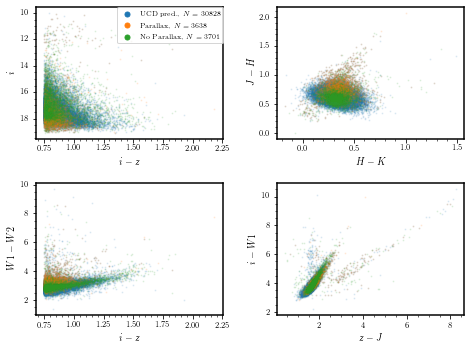

In [ ]:
fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
plt.subplot(2,2,1)

alpha = 0.1

ax0=plt.scatter(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean[imag],
           s=1,c='C0',label='UCD pred., $N = {}$'.format(len(smss_dwarfs_clean)),rasterized=True)
ax1=plt.scatter(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar[imag],
           s=1,c='C1',label='Parallax, $N = {}$'.format(len(new_smss_pospar)))
ax2=plt.scatter(new_smss_nopospoar[imag]-new_smss_nopospoar[zmag],new_smss_nopospoar[imag],
           s=1,c='C2',label='No Parallax, $N = {}$'.format(len(new_smss_nopospoar)))
plt.xlabel('$i - z$')
plt.ylabel('$i$')
plt.minorticks_on()
plt.legend()
plt.gca().invert_yaxis()
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
ax0.set_alpha(alpha)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,2)

ax0=plt.scatter(smss_dwarfs_clean[hmag]-smss_dwarfs_clean[kmag],smss_dwarfs_clean[jmag]-smss_dwarfs_clean[hmag],
           s=1,c='C0',rasterized=True)
ax1=plt.scatter(new_smss_pospar[hmag]-new_smss_pospar[kmag],new_smss_pospar[jmag]-new_smss_pospar[hmag],
           s=1,c='C1')
ax2=plt.scatter(new_smss_nopospoar[hmag]-new_smss_nopospoar[kmag],new_smss_nopospoar[jmag]-new_smss_nopospoar[hmag],
           s=1,c='C2')
plt.xlabel('$H - K$')
plt.ylabel('$J - H$')
plt.minorticks_on()
#plt.gca().invert_yaxis()
ax0.set_alpha(alpha)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,3)
ax0=plt.scatter(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean[zmag]-smss_dwarfs_clean[w1mag],
           s=1,c='C0',rasterized=True)
ax1=plt.scatter(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar[zmag]-new_smss_pospar[w1mag],
           s=1,c='C1')
ax2=plt.scatter(new_smss_nopospoar[imag]-new_smss_nopospoar[zmag],new_smss_nopospoar[zmag]-new_smss_nopospoar[w1mag],
           s=1,c='C2')
plt.xlabel('$i - z$')
plt.ylabel('$W1 - W2$')
plt.minorticks_on()
#plt.legend()
#plt.gca().invert_yaxis()
ax0.set_alpha(alpha)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,4)
ax0=plt.scatter(smss_dwarfs_clean[zmag]-smss_dwarfs_clean[jmag],smss_dwarfs_clean[imag]-smss_dwarfs_clean[w1mag],
           s=1,c='C0',rasterized=True)
ax1=plt.scatter(new_smss_pospar[zmag]-new_smss_pospar[jmag],new_smss_pospar[imag]-new_smss_pospar[w1mag],
           s=1,c='C1')
ax2=plt.scatter(new_smss_nopospoar[zmag]-new_smss_nopospoar[jmag],new_smss_nopospoar[imag]-new_smss_nopospoar[w1mag],
           s=1,c='C2')
plt.xlabel('$z - J$')
plt.ylabel('$i - W1$')
plt.minorticks_on()
#plt.gca().invert_yaxis()
ax0.set_alpha(alpha)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_par_nopar_preds_new.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

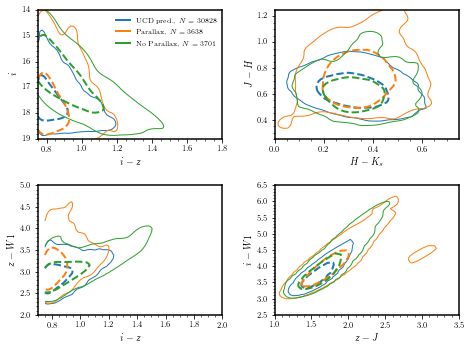

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))

ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

imag,zmag = 'i_psf','z_psf'
jmag,hmag,kmag = 'j_m','h_m','k_m'
gmag,rpmag = 'phot_g_mean_mag','phot_rp_mean_mag'
w1mag,w1mag = 'w1mpro','w2mpro'

# ax plot
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean[imag])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar[imag])
X3,Y3,Z3 = gauss_levels(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss[imag])
levels_1 = conf_levels(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean[imag],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar[imag],bin_n = 25)
levels_3 = conf_levels(near_dwarfs_smss[imag]-near_dwarfs_smss[zmag],near_dwarfs_smss[imag],bin_n = 25)

axis1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax.set_xlabel('$i - z$')
ax.set_ylabel('$i$')
ax.set_xlim(0.75,1.8)
ax.set_ylim(14,19)
ax.invert_yaxis()
ax.minorticks_on()

#ax2
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[hmag]-smss_dwarfs_clean[kmag],smss_dwarfs_clean[jmag]-smss_dwarfs_clean[hmag])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[hmag]-new_smss_pospar[kmag],new_smss_pospar[jmag]-new_smss_pospar[hmag])
X3,Y3,Z3 = gauss_levels(new_smss_nopospoar[hmag]-new_smss_nopospoar[kmag],new_smss_nopospoar[jmag]-new_smss_nopospoar[hmag])

# need these df's because gaia photometry contains nans, and the level's function np.histogram doesn't account for nans.
#df = smss_dwarfs_clean[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
#df2 = new_smss_pospar[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')
#df3 = near_dwarfs_smss[[gmag,'phot_rp_mean_mag','M_phot_g_mean_mag']].dropna(how='any')

levels_1 = conf_levels(smss_dwarfs_clean[hmag]-smss_dwarfs_clean[kmag],smss_dwarfs_clean[jmag]-smss_dwarfs_clean[hmag],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[hmag]-new_smss_pospar[kmag],new_smss_pospar[jmag]-new_smss_pospar[hmag],bin_n = 25)
levels_3 = conf_levels(new_smss_nopospoar[hmag]-new_smss_nopospoar[kmag],new_smss_nopospoar[jmag]-new_smss_nopospoar[hmag],bin_n = 25)

axis1 = ax2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2.set_xlabel('$H - K_s$')
ax2.set_ylabel('$J - H$')
#ax2.invert_yaxis()
ax2.set_xlim(0.0,0.75)
ax2.set_ylim(0.25,1.25)
ax2.minorticks_on()

#ax3
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean[zmag]-smss_dwarfs_clean[w1mag])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar[zmag]-new_smss_pospar[w1mag])
X3,Y3,Z3 = gauss_levels(new_smss_nopospoar[imag]-new_smss_nopospoar[zmag],new_smss_nopospoar[zmag]-new_smss_nopospoar[w1mag])
levels_1 = conf_levels(smss_dwarfs_clean[imag]-smss_dwarfs_clean[zmag],smss_dwarfs_clean[zmag]-smss_dwarfs_clean[w1mag],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[imag]-new_smss_pospar[zmag],new_smss_pospar[zmag]-new_smss_pospar[w1mag],bin_n = 25)
levels_3 = conf_levels(new_smss_nopospoar[imag]-new_smss_nopospoar[zmag],new_smss_nopospoar[zmag]-new_smss_nopospoar[w1mag],bin_n = 25)

axis1 = ax3.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax3.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax3.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3.set_xlabel('$i - z$')
ax3.set_ylabel('$z - W1$')
#ax3.invert_yaxis()
ax3.set_xlim(0.70,2.0)
ax3.set_ylim(2,5)
ax3.minorticks_on()

#ax4
X1,Y1,Z1 = gauss_levels(smss_dwarfs_clean[zmag]-smss_dwarfs_clean[jmag],smss_dwarfs_clean[imag]-smss_dwarfs_clean[w1mag])
X2,Y2,Z2 = gauss_levels(new_smss_pospar[zmag]-new_smss_pospar[jmag],new_smss_pospar[imag]-new_smss_pospar[w1mag])
X3,Y3,Z3 = gauss_levels(new_smss_nopospoar[zmag]-new_smss_nopospoar[jmag],new_smss_nopospoar[imag]-new_smss_nopospoar[w1mag])
levels_1 = conf_levels(smss_dwarfs_clean[zmag]-smss_dwarfs_clean[jmag],smss_dwarfs_clean[imag]-smss_dwarfs_clean[w1mag],bin_n = 25)
levels_2 = conf_levels(new_smss_pospar[zmag]-new_smss_pospar[jmag],new_smss_pospar[imag]-new_smss_pospar[w1mag],bin_n = 25)
levels_3 = conf_levels(new_smss_nopospoar[zmag]-new_smss_nopospoar[jmag],new_smss_nopospoar[imag]-new_smss_nopospoar[w1mag],bin_n = 25)

axis1 = ax4.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis2 = ax4.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
axis3 = ax4.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4.set_xlabel('$z - J$')
ax4.set_ylabel('$i - W1$')
#ax4.invert_yaxis()
ax4.set_xlim(1,3.5)
ax4.set_ylim(2.5,6.5)
ax4.minorticks_on()

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD pred., $N = {}$'.format(len(smss_dwarfs_clean)))
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'Parallax, $N = {}$'.format(len(new_smss_pospar)))
ax.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'No Parallax, $N = {}$'.format(len(new_smss_nopospoar)))

ax.legend(loc='upper right', frameon=False)


plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_par_nopar_preds_new_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# Getting SPT relationship and cutting along $i - z$

In [ ]:
plt.rc('axes', linewidth=2.5) # change back to 1.5
plt.rc('axes', labelsize=15) # change back to 10
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=15) # change back to 7

In [ ]:
path_kiman = 'gdrive/My Drive/Colab Notebooks/kiman_etal_mdwarfs/'
kiman_smss =  pd.read_csv(path_kiman+'kiman_goodastro_spt_calibrated_sm.csv')
kiman_smss = kiman_smss[kiman_smss['angDist'] <= 5.0]
kiman_smss.shape

(7166, 141)

In [ ]:
kiman_sm_merged = smss_refset.merge(kiman_smss,left_on='object_id',right_on='ObjectId',suffixes=('','_dup'))
kiman_sm_merged = kiman_sm_merged.drop(kiman_sm_merged.filter(regex='_dup').columns, axis=1)
kiman_sm_merged.shape

(185, 497)

In [ ]:
kiman = kiman_sm_merged[['object_id','i_psf','z_psf','j_m','h_m','k_m','w1mpro','w2mpro','parallax',
                   'spt_calibrated','spt_calibrated_num','survey_marker']]

         2
0.01478 x - 0.06995 x + 0.7583


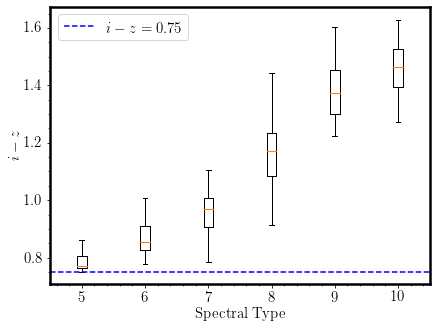

In [ ]:
x = kiman['spt_calibrated_num']
x = x.values
y = kiman['i_psf'] - kiman['z_psf']
y = y.values


########### Done creating fake data


## Create the figure
plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))

# Plot the data
#plt.errorbar(x,y, yerr=yerr, ls='None')

# Boxplot the data
#data = [data, d2, d2[::2, 0]]
for i in np.unique(x):
    j = np.where(x == i)
    plt.boxplot(y[j], positions=[i], vert=True, showfliers=False)


# fit a line (first degree polynomial) to the data
z1 = np.polyfit(x, y, 1)
# fit a second degree polynomial to the data
z2 = np.polyfit(x, y, 2)

# create functions for the polynomials (we can just input the 'X' value to get the 'Y' value from the polynomail)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)
print(p2)
# Plot the polynomials
#xplot = np.linspace(np.min(x),np.max(x))
#plt.plot(xplot, p1(xplot), 'r-', label='1st order', alpha=0.5)
#plt.plot(xplot, p2(xplot), 'm-', label='2nd order', alpha=0.5)
plt.axhline(y=0.75,ls='--',color='b',label='$i-z = 0.75$')
#plt.xlim(np.min(x)-1, np.max(x)+1)
#plt.ylim(0.7,0.9)
plt.minorticks_on()
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('$i - z$')
plt.xlabel('Spectral Type')
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_spt_box_izline.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# DES now:

In [ ]:
kiman_goodastro = pd.read_csv(path_kiman+'/kiman_goodastro_spt_calibrated.csv')
kiman_goodastro.shape

(23842, 97)

In [ ]:
kiman_des = pd.read_csv(path_des+'kiman_goodastro_des_robcuts_coords.csv') # des rob cuts x kiman good astro
kiman_des.shape

(376, 6)

In [ ]:
list(kiman_des)

['COADD_OBJECT_ID', 'RA', 'DEC', 'RAdegG', 'DEdegG', 'Separation']

In [ ]:
kiman_spt_merged = kiman_goodastro.merge(kiman_des,on='DEdegG',how='inner')
kiman_spt_merged_nodupes = kiman_spt_merged.drop_duplicates('DEdegG')
kiman_spt_merged_nodupes.shape

(376, 102)

In [ ]:
kiman_des_merged = des_refset.merge(kiman_spt_merged_nodupes,on='COADD_OBJECT_ID',suffixes=('','_dup'))
kiman_des_merged = kiman_des_merged.drop(kiman_des_merged.filter(regex='_dup').columns, axis=1)
kiman_des_merged.shape

(224, 335)

In [ ]:
# getting num spt:
spt_calibrated_num = []
for spt in kiman_des_merged['spt_calibrated']:
    for i in np.arange(10):
        if spt == 'M{}'.format(i):
            spt_calibrated_num.append(i)
        if spt == 'L{}'.format(i):
            spt_calibrated_num.append(i+10)
        if spt == 'T{}'.format(i):
            spt_calibrated_num.append(i+20)

kiman_des_merged['spt_calibrated_num'] = spt_calibrated_num

         2
0.03313 x - 0.3137 x + 1.528


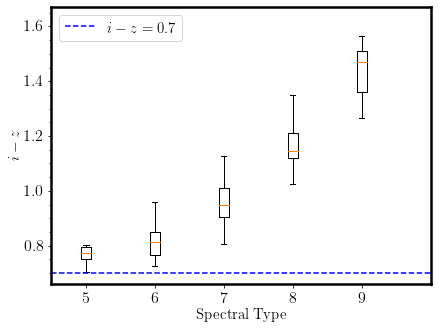

In [ ]:
x = kiman_des_merged['spt_calibrated_num']
x = x.values
y = kiman_des_merged['IMAG_DERED'] - kiman_des_merged['ZMAG_DERED']
y = y.values


## Create the figure
plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))

# Plot the data
#plt.errorbar(x,y, yerr=yerr, ls='None')

# Boxplot the data
#data = [data, d2, d2[::2, 0]]

for i in np.unique(x):
    j = np.where(x == i)
    plt.boxplot(y[j], positions=[i], vert=True, showfliers=False)


# fit a line (first degree polynomial) to the data
z1 = np.polyfit(x, y, 1)
# fit a second degree polynomial to the data
z2 = np.polyfit(x, y, 2)

# create functions for the polynomials (we can just input the 'X' value to get the 'Y' value from the polynomail)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)
print(p2)
# Plot the polynomials
#xplot = np.linspace(np.min(x),np.max(x))
#plt.plot(xplot, p1(xplot), 'r-', label='1st order', alpha=0.5)
#plt.plot(xplot, p2(xplot), 'm-', label='2nd order', alpha=0.5)
plt.axhline(y=0.70,ls='--',color='b',label='$i-z = 0.7$')
plt.xlim(4.5, 10)
#plt.ylim(0.70,0.9)
plt.minorticks_on()
plt.legend()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('$i - z$')
plt.xlabel('Spectral Type')
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_spt_box_izline.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()